In [1]:
%matplotlib widget
%matplotlib inline
import torch
import torch.nn as nn
import pickle
import time
import copy
import os
from queue import LifoQueue
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.tree import DecisionTreeClassifier
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances
import network.cpc
from network.cpc import CDCK2
from utils.MatplotlibUtils import reduce_dims_and_plot
from utils.ClassificationUtiols import onehot_coding
from soft_decision_tree.sdt_model import SDT
from sklearn import tree as tt

# IPython.OutputArea.auto_scroll_threshold = 9999;

# Load the model and the dataset

In [2]:
model_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_32/models/epoch_45.pt'
dataset_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_32/data/test_data_protocol_4.file'

print(f"Load the model from: {model_path}")
model = torch.load(model_path, map_location='cpu')

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)

all_sensors = dataset.dataset.all_signals    
print(f"sensor names: ({len(all_sensors)} total)")

for s in all_sensors:
    print(f"- {s}")
    
print(f"Multihorizon size of the model: {model.timestep}")
print(f"Test split ratio: {len(dataset) / len(dataset.dataset)}")
print(f"Total number of windows in the dataset (without splitting): {len(dataset.dataset)}")

Load the model from: /home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_32/models/epoch_45.pt
sensor names: (18 total)
- speed
- steering_angle
- wheel_speed_0
- wheel_speed_1
- wheel_speed_2
- wheel_speed_3
- accelerometer_0
- accelerometer_1
- accelerometer_2
- gyro_0
- gyro_1
- gyro_2
- gyro_bias_0
- gyro_bias_1
- gyro_bias_2
- gyro_uncalibrated_0
- gyro_uncalibrated_1
- gyro_uncalibrated_2
Multihorizon size of the model: 30
Test split ratio: 0.2
Total number of windows in the dataset (without splitting): 101465


In [3]:
batch_size = 500
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Extract representations

In [4]:
projections = torch.tensor([])
samples = torch.tensor([])
device = 'cuda'
model = model.to(device).eval()

with torch.no_grad():
    bar = tqdm(total=len(loader.dataset))
    for batch in loader:
        hidden = CDCK2.init_hidden(len(batch))
        batch = batch.to(device)
        hidden = hidden.to(device)

        y = model.predict(batch, hidden).detach().cpu()
        projections = torch.cat([projections, y.detach().cpu()])
        samples = torch.cat([samples, batch.detach().cpu()])
        bar.update(y.shape[0])

# Fit GMM and calculate indices

In [5]:
scores = []
best_score = float('inf')
clusters = None
range_ = list(range(5, 80))
for k in tqdm(range_):
    y = GaussianMixture(n_components=k).fit_predict(projections)
    cur_score = davies_bouldin_score(projections, y)
    scores.append(cur_score)
    
    if cur_score < best_score:
        best_score = cur_score
        clusters = y

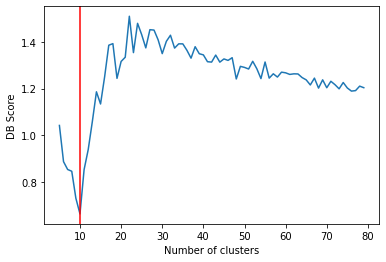

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [6]:
plt.figure()
plt.xlabel('Number of clusters')
plt.ylabel('DB Score')
plt.plot(range_, scores)
best_k = range_[np.argmin(scores)]
plt.axvline(best_k, color='r')
plt.show()

labels = set(clusters)
print(labels)

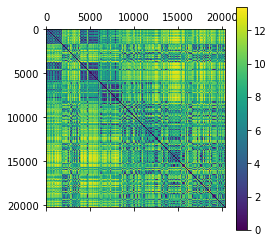

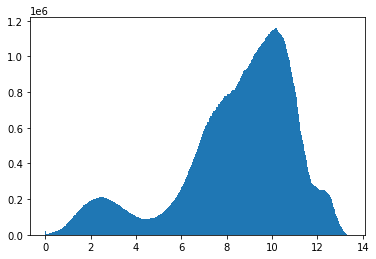

In [7]:
distances = pairwise_distances(projections)
# distances = np.triu(distances)
distances_f = distances.flatten()

plt.matshow(distances)
plt.colorbar()
plt.figure()
plt.hist(distances_f[distances_f > 0], bins=1000)
plt.show()

# Visualize with T-SNE

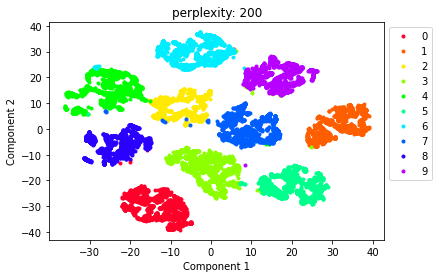

In [8]:
perplexity = 200

p = reduce_dims_and_plot(projections,
                         y=clusters,
                         title=f'perplexity: {perplexity}',
                         file_name=None,
                         perplexity=perplexity,
                         library='Multicore-TSNE',
                         perform_PCA=False,
                         projected=None,
                         figure_type='2d',
                         show_figure=True,
                         close_figure=False,
                         text=None)    

# Train a Soft-Decision-Tree given the self-labels

## Prepare the dataset

In [9]:
# unnormalized_samples = samples.clone()

# for col, sensor in enumerate(tqdm(dataset.dataset.all_signals)):
#     denormalizer = dataset.dataset.get_denormalization_for_sensor(sensor)
#     unnormalized_samples[:, col, :] = denormalizer(unnormalized_samples[:, col, :])

sampled = samples[..., range(0, samples.shape[-1], 200)]

samples_f = sampled.flatten(1)
tree_dataset = list(zip(samples_f, clusters))
batch_size = 2000
tree_loader = torch.utils.data.DataLoader(tree_dataset, batch_size=batch_size, shuffle=True)

# Define how we prune the weights of a node

In [10]:
def prune_node(node_weights, factor=1):
    w = node_weights.cpu().detach().numpy()
    mean_ = np.mean(w)
    std_ = np.std(w)
    node_weights[((mean_ - std_ * factor) < node_weights) & (node_weights < (mean_ + std_ * factor))] = 0
    return node_weights

def prune_node_keep(node_weights, keep=4):
    w = node_weights.cpu().detach().numpy()
    throw_idx = np.argsort(abs(w))[:-keep]
    node_weights[throw_idx] = 0
    return node_weights

def prune_tree(tree_, factor):
    new_weights = tree_.inner_nodes.weight.clone()
    for i in range(new_weights.shape[0]):
        res = prune_node_keep(new_weights[i, :], factor)
        new_weights[i, :] = res

    with torch.no_grad():
        tree_.inner_nodes.weight.copy_(new_weights)
        
def sparseness(x):
    s = []
    for i in range(x.shape[0]):
        x_ = x[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        s.append(sp)
    return np.mean(s)

def compute_regularization_by_level(tree):
    total_reg = 0
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_level = np.floor(np.log2(i+1))
        node_reg = torch.norm(tree.inner_nodes.weight[i].view(-1), 2)
        total_reg += 2**(-cur_level) * node_reg
    return total_reg

def show_sparseness(tree):
    avg_sp = sparseness(tree.inner_nodes.weight)
    print(f"Average sparseness: {avg_sp}")
    layer = 0
    sps = []
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_layer = int(np.floor(np.log2(i+1)))
        if cur_layer != layer:
            print(f"layer {layer}: {np.mean(sps)}")
            sps = []
            layer = cur_layer

        x_ = tree.inner_nodes.weight[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        sps.append(sp)
        
    return avg_sp

## Training configurations

In [11]:
def do_epoch(model, loader, device, log_interval, losses, accs, epoch, iteration):
    model = model.train()
    for batch_idx, (data, target) in enumerate(loader):
        iteration += 1
        data, target = data.to(device), target.to(device)

        output, penalty = tree.forward(data)

        # Loss
        loss_tree = criterion(output, target.view(-1))

        # Penalty
        loss_tree += penalty

        # Sparse regularization
#         fc_params = torch.cat([x.view(-1) for x in tree.inner_nodes.parameters()])
#         regularization = sparsity_lamda * torch.norm(fc_params, 2)
        regularization = sparsity_lamda * compute_regularization_by_level(tree)
        loss = loss_tree

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        pred = output.data.max(1)[1]
        correct = pred.eq(target.view(-1).data).sum()
        accs.append(correct.item() / data.size()[0])

        # Print training status
        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch:02d} | Batch: {batch_idx:03d} / {len(loader):03d} | Total loss: {loss.item():.3f} | Reg loss: {regularization.item():.3f} | Tree loss: {loss_tree.item():.3f} | Accuracy: {correct.item() / data.size()[0]:03f} | {round((time.time() - start_time) / iteration, 3)} sec/iter")
            
    return iteration


In [12]:
lr = 5e-3
weight_decay = 5e-4
sparsity_lamda = 2e-3
epochs = 500
output_dim = len(set(clusters))
log_interval = 1
tree_depth = 10

In [13]:
tree = SDT(input_dim=samples_f.shape[1], output_dim=len(labels), depth=tree_depth, lamda=1e-3, use_cuda=True)
optimizer = torch.optim.Adam(tree.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
tree = tree.to(device)
clf = DecisionTreeClassifier(max_depth=tree_depth).fit(samples_f, clusters)
print(f"DT accuracy: {clf.score(samples_f, clusters)}")
tree.initialize_from_decision_tree(clf)

DT accuracy: 0.9920169516582072


In [14]:
losses = []
accs = []
sparsity = []

In [15]:
start_time = time.time()
iteration = 0
for epoch in range(epochs):
    # Training
    avg_sp = show_sparseness(tree)
    sparsity.append(avg_sp)
    iteration = do_epoch(tree, tree_loader, device, log_interval, losses, accs, epoch, iteration)
    
    if epoch % 1 == 0:
        prune_tree(tree, factor=5)
        

Average sparseness: 0.2600465535771186
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.9271408839779005
layer 5: 0.7108080110497237
layer 6: 0.587189226519337
layer 7: 0.4558442679558012
layer 8: 0.25496374309392267
Epoch: 00 | Batch: 000 / 011 | Total loss: 2.300 | Reg loss: 0.019 | Tree loss: 2.300 | Accuracy: 0.102500 | 1.388 sec/iter
Epoch: 00 | Batch: 001 / 011 | Total loss: 2.289 | Reg loss: 0.018 | Tree loss: 2.289 | Accuracy: 0.127500 | 1.206 sec/iter
Epoch: 00 | Batch: 002 / 011 | Total loss: 2.277 | Reg loss: 0.018 | Tree loss: 2.277 | Accuracy: 0.239500 | 1.154 sec/iter
Epoch: 00 | Batch: 003 / 011 | Total loss: 2.267 | Reg loss: 0.018 | Tree loss: 2.267 | Accuracy: 0.313500 | 1.121 sec/iter
Epoch: 00 | Batch: 004 / 011 | Total loss: 2.262 | Reg loss: 0.018 | Tree loss: 2.262 | Accuracy: 0.337000 | 1.102 sec/iter
Epoch: 00 | Batch: 005 / 011 | Total loss: 2.253 | Reg loss: 0.018 | Tree loss: 2.253 | Accur

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 05 | Batch: 000 / 011 | Total loss: 2.250 | Reg loss: 0.016 | Tree loss: 2.250 | Accuracy: 0.293000 | 1.215 sec/iter
Epoch: 05 | Batch: 001 / 011 | Total loss: 2.236 | Reg loss: 0.016 | Tree loss: 2.236 | Accuracy: 0.407000 | 1.21 sec/iter
Epoch: 05 | Batch: 002 / 011 | Total loss: 2.223 | Reg loss: 0.017 | Tree loss: 2.223 | Accuracy: 0.423000 | 1.206 sec/iter
Epoch: 05 | Batch: 003 / 011 | Total loss: 2.204 | Reg loss: 0.017 | Tree loss: 2.204 | Accuracy: 0.421000 | 1.203 sec/iter
Epoch: 05 | Batch: 004 / 011 | Total loss: 2.178 | Reg loss: 0.017 | Tree loss: 2.178 | Accuracy: 0.389000 | 1.201 sec/iter
Epoch: 05 | Batch: 005 / 011 | Total loss: 2.162 | Reg loss: 0.017 | Tree loss: 2.162 | Ac

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 10 | Batch: 000 / 011 | Total loss: 2.173 | Reg loss: 0.019 | Tree loss: 2.173 | Accuracy: 0.321500 | 1.176 sec/iter
Epoch: 10 | Batch: 001 / 011 | Total loss: 2.141 | Reg loss: 0.019 | Tree loss: 2.141 | Accuracy: 0.342000 | 1.174 sec/iter
Epoch: 10 | Batch: 002 / 011 | Total loss: 2.104 | Reg loss: 0.019 | Tree loss: 2.104 | Accuracy: 0.313000 | 1.173 sec/iter
Epoch: 10 | Batch: 003 / 011 | Total loss: 2.056 | Reg loss: 0.019 | Tree loss: 2.056 | Accuracy: 0.395500 | 1.172 sec/iter
Epoch: 10 | Batch: 004 / 011 | Total loss: 2.007 | Reg loss: 0.019 | Tree loss: 2.007 | Accuracy: 0.429500 | 1.171 sec/iter
Epoch: 10 | Batch: 005 / 011 | Total loss: 1.971 | Reg loss: 0.020 | Tree loss: 1.971 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 15 | Batch: 000 / 011 | Total loss: 2.041 | Reg loss: 0.021 | Tree loss: 2.041 | Accuracy: 0.345500 | 1.164 sec/iter
Epoch: 15 | Batch: 001 / 011 | Total loss: 1.992 | Reg loss: 0.021 | Tree loss: 1.992 | Accuracy: 0.358500 | 1.164 sec/iter
Epoch: 15 | Batch: 002 / 011 | Total loss: 1.932 | Reg loss: 0.021 | Tree loss: 1.932 | Accuracy: 0.365000 | 1.163 sec/iter
Epoch: 15 | Batch: 003 / 011 | Total loss: 1.873 | Reg loss: 0.021 | Tree loss: 1.873 | Accuracy: 0.381500 | 1.162 sec/iter
Epoch: 15 | Batch: 004 / 011 | Total loss: 1.832 | Reg loss: 0.021 | Tree loss: 1.832 | Accuracy: 0.421000 | 1.162 sec/iter
Epoch: 15 | Batch: 005 / 011 | Total loss: 1.784 | Reg loss: 0.021 | Tree loss: 1.784 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 20 | Batch: 000 / 011 | Total loss: 1.872 | Reg loss: 0.022 | Tree loss: 1.872 | Accuracy: 0.361000 | 1.166 sec/iter
Epoch: 20 | Batch: 001 / 011 | Total loss: 1.817 | Reg loss: 0.022 | Tree loss: 1.817 | Accuracy: 0.362500 | 1.165 sec/iter
Epoch: 20 | Batch: 002 / 011 | Total loss: 1.762 | Reg loss: 0.022 | Tree loss: 1.762 | Accuracy: 0.409500 | 1.163 sec/iter
Epoch: 20 | Batch: 003 / 011 | Total loss: 1.719 | Reg loss: 0.022 | Tree loss: 1.719 | Accuracy: 0.423500 | 1.162 sec/iter
Epoch: 20 | Batch: 004 / 011 | Total loss: 1.665 | Reg loss: 0.022 | Tree loss: 1.665 | Accuracy: 0.486000 | 1.161 sec/iter
Epoch: 20 | Batch: 005 / 011 | Total loss: 1.630 | Reg loss: 0.023 | Tree loss: 1.630 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 25 | Batch: 000 / 011 | Total loss: 1.725 | Reg loss: 0.023 | Tree loss: 1.725 | Accuracy: 0.412000 | 1.168 sec/iter
Epoch: 25 | Batch: 001 / 011 | Total loss: 1.670 | Reg loss: 0.023 | Tree loss: 1.670 | Accuracy: 0.423500 | 1.167 sec/iter
Epoch: 25 | Batch: 002 / 011 | Total loss: 1.628 | Reg loss: 0.023 | Tree loss: 1.628 | Accuracy: 0.449500 | 1.166 sec/iter
Epoch: 25 | Batch: 003 / 011 | Total loss: 1.582 | Reg loss: 0.023 | Tree loss: 1.582 | Accuracy: 0.457500 | 1.166 sec/iter
Epoch: 25 | Batch: 004 / 011 | Total loss: 1.545 | Reg loss: 0.023 | Tree loss: 1.545 | Accuracy: 0.502500 | 1.165 sec/iter
Epoch: 25 | Batch: 005 / 011 | Total loss: 1.490 | Reg loss: 0.023 | Tree loss: 1.490 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 30 | Batch: 000 / 011 | Total loss: 1.598 | Reg loss: 0.023 | Tree loss: 1.598 | Accuracy: 0.436000 | 1.162 sec/iter
Epoch: 30 | Batch: 001 / 011 | Total loss: 1.538 | Reg loss: 0.023 | Tree loss: 1.538 | Accuracy: 0.490500 | 1.162 sec/iter
Epoch: 30 | Batch: 002 / 011 | Total loss: 1.513 | Reg loss: 0.023 | Tree loss: 1.513 | Accuracy: 0.485000 | 1.161 sec/iter
Epoch: 30 | Batch: 003 / 011 | Total loss: 1.481 | Reg loss: 0.023 | Tree loss: 1.481 | Accuracy: 0.469500 | 1.161 sec/iter
Epoch: 30 | Batch: 004 / 011 | Total loss: 1.434 | Reg loss: 0.023 | Tree loss: 1.434 | Accuracy: 0.528000 | 1.16 sec/iter
Epoch: 30 | Batch: 005 / 011 | Total loss: 1.376 | Reg loss: 0.023 | Tree loss: 1.376 | Ac

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 35 | Batch: 000 / 011 | Total loss: 1.498 | Reg loss: 0.023 | Tree loss: 1.498 | Accuracy: 0.469500 | 1.159 sec/iter
Epoch: 35 | Batch: 001 / 011 | Total loss: 1.452 | Reg loss: 0.023 | Tree loss: 1.452 | Accuracy: 0.496000 | 1.158 sec/iter
Epoch: 35 | Batch: 002 / 011 | Total loss: 1.406 | Reg loss: 0.024 | Tree loss: 1.406 | Accuracy: 0.495500 | 1.158 sec/iter
Epoch: 35 | Batch: 003 / 011 | Total loss: 1.399 | Reg loss: 0.024 | Tree loss: 1.399 | Accuracy: 0.519000 | 1.157 sec/iter
Epoch: 35 | Batch: 004 / 011 | Total loss: 1.349 | Reg loss: 0.024 | Tree loss: 1.349 | Accuracy: 0.532500 | 1.157 sec/iter
Epoch: 35 | Batch: 005 / 011 | Total loss: 1.319 | Reg loss: 0.024 | Tree loss: 1.319 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 40 | Batch: 000 / 011 | Total loss: 1.419 | Reg loss: 0.024 | Tree loss: 1.419 | Accuracy: 0.507000 | 1.156 sec/iter
Epoch: 40 | Batch: 001 / 011 | Total loss: 1.404 | Reg loss: 0.024 | Tree loss: 1.404 | Accuracy: 0.495500 | 1.155 sec/iter
Epoch: 40 | Batch: 002 / 011 | Total loss: 1.377 | Reg loss: 0.024 | Tree loss: 1.377 | Accuracy: 0.520000 | 1.155 sec/iter
Epoch: 40 | Batch: 003 / 011 | Total loss: 1.337 | Reg loss: 0.024 | Tree loss: 1.337 | Accuracy: 0.549000 | 1.155 sec/iter
Epoch: 40 | Batch: 004 / 011 | Total loss: 1.285 | Reg loss: 0.024 | Tree loss: 1.285 | Accuracy: 0.563000 | 1.155 sec/iter
Epoch: 40 | Batch: 005 / 011 | Total loss: 1.291 | Reg loss: 0.024 | Tree loss: 1.291 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 45 | Batch: 000 / 011 | Total loss: 1.393 | Reg loss: 0.024 | Tree loss: 1.393 | Accuracy: 0.512500 | 1.156 sec/iter
Epoch: 45 | Batch: 001 / 011 | Total loss: 1.335 | Reg loss: 0.024 | Tree loss: 1.335 | Accuracy: 0.535000 | 1.156 sec/iter
Epoch: 45 | Batch: 002 / 011 | Total loss: 1.331 | Reg loss: 0.024 | Tree loss: 1.331 | Accuracy: 0.537500 | 1.155 sec/iter
Epoch: 45 | Batch: 003 / 011 | Total loss: 1.272 | Reg loss: 0.024 | Tree loss: 1.272 | Accuracy: 0.551000 | 1.155 sec/iter
Epoch: 45 | Batch: 004 / 011 | Total loss: 1.244 | Reg loss: 0.024 | Tree loss: 1.244 | Accuracy: 0.556000 | 1.155 sec/iter
Epoch: 45 | Batch: 005 / 011 | Total loss: 1.238 | Reg loss: 0.024 | Tree loss: 1.238 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 50 | Batch: 000 / 011 | Total loss: 1.330 | Reg loss: 0.024 | Tree loss: 1.330 | Accuracy: 0.546000 | 1.157 sec/iter
Epoch: 50 | Batch: 001 / 011 | Total loss: 1.306 | Reg loss: 0.024 | Tree loss: 1.306 | Accuracy: 0.576500 | 1.156 sec/iter
Epoch: 50 | Batch: 002 / 011 | Total loss: 1.299 | Reg loss: 0.024 | Tree loss: 1.299 | Accuracy: 0.597000 | 1.156 sec/iter
Epoch: 50 | Batch: 003 / 011 | Total loss: 1.272 | Reg loss: 0.024 | Tree loss: 1.272 | Accuracy: 0.585500 | 1.155 sec/iter
Epoch: 50 | Batch: 004 / 011 | Total loss: 1.228 | Reg loss: 0.024 | Tree loss: 1.228 | Accuracy: 0.600500 | 1.155 sec/iter
Epoch: 50 | Batch: 005 / 011 | Total loss: 1.216 | Reg loss: 0.024 | Tree loss: 1.216 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 55 | Batch: 000 / 011 | Total loss: 1.311 | Reg loss: 0.024 | Tree loss: 1.311 | Accuracy: 0.544500 | 1.159 sec/iter
Epoch: 55 | Batch: 001 / 011 | Total loss: 1.286 | Reg loss: 0.024 | Tree loss: 1.286 | Accuracy: 0.585500 | 1.158 sec/iter
Epoch: 55 | Batch: 002 / 011 | Total loss: 1.244 | Reg loss: 0.024 | Tree loss: 1.244 | Accuracy: 0.596500 | 1.158 sec/iter
Epoch: 55 | Batch: 003 / 011 | Total loss: 1.245 | Reg loss: 0.024 | Tree loss: 1.245 | Accuracy: 0.589000 | 1.158 sec/iter
Epoch: 55 | Batch: 004 / 011 | Total loss: 1.207 | Reg loss: 0.024 | Tree loss: 1.207 | Accuracy: 0.605500 | 1.158 sec/iter
Epoch: 55 | Batch: 005 / 011 | Total loss: 1.182 | Reg loss: 0.024 | Tree loss: 1.182 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 60 | Batch: 000 / 011 | Total loss: 1.276 | Reg loss: 0.024 | Tree loss: 1.276 | Accuracy: 0.592500 | 1.157 sec/iter
Epoch: 60 | Batch: 001 / 011 | Total loss: 1.257 | Reg loss: 0.024 | Tree loss: 1.257 | Accuracy: 0.609500 | 1.157 sec/iter
Epoch: 60 | Batch: 002 / 011 | Total loss: 1.233 | Reg loss: 0.024 | Tree loss: 1.233 | Accuracy: 0.611000 | 1.156 sec/iter
Epoch: 60 | Batch: 003 / 011 | Total loss: 1.188 | Reg loss: 0.024 | Tree loss: 1.188 | Accuracy: 0.613000 | 1.156 sec/iter
Epoch: 60 | Batch: 004 / 011 | Total loss: 1.187 | Reg loss: 0.024 | Tree loss: 1.187 | Accuracy: 0.604000 | 1.156 sec/iter
Epoch: 60 | Batch: 005 / 011 | Total loss: 1.163 | Reg loss: 0.024 | Tree loss: 1.163 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 65 | Batch: 000 / 011 | Total loss: 1.277 | Reg loss: 0.024 | Tree loss: 1.277 | Accuracy: 0.599500 | 1.155 sec/iter
Epoch: 65 | Batch: 001 / 011 | Total loss: 1.252 | Reg loss: 0.024 | Tree loss: 1.252 | Accuracy: 0.624000 | 1.154 sec/iter
Epoch: 65 | Batch: 002 / 011 | Total loss: 1.210 | Reg loss: 0.024 | Tree loss: 1.210 | Accuracy: 0.616000 | 1.154 sec/iter
Epoch: 65 | Batch: 003 / 011 | Total loss: 1.201 | Reg loss: 0.024 | Tree loss: 1.201 | Accuracy: 0.593500 | 1.154 sec/iter
Epoch: 65 | Batch: 004 / 011 | Total loss: 1.164 | Reg loss: 0.024 | Tree loss: 1.164 | Accuracy: 0.614500 | 1.154 sec/iter
Epoch: 65 | Batch: 005 / 011 | Total loss: 1.145 | Reg loss: 0.024 | Tree loss: 1.145 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 70 | Batch: 000 / 011 | Total loss: 1.242 | Reg loss: 0.024 | Tree loss: 1.242 | Accuracy: 0.621500 | 1.154 sec/iter
Epoch: 70 | Batch: 001 / 011 | Total loss: 1.244 | Reg loss: 0.024 | Tree loss: 1.244 | Accuracy: 0.613500 | 1.153 sec/iter
Epoch: 70 | Batch: 002 / 011 | Total loss: 1.208 | Reg loss: 0.024 | Tree loss: 1.208 | Accuracy: 0.611500 | 1.153 sec/iter
Epoch: 70 | Batch: 003 / 011 | Total loss: 1.159 | Reg loss: 0.025 | Tree loss: 1.159 | Accuracy: 0.611000 | 1.153 sec/iter
Epoch: 70 | Batch: 004 / 011 | Total loss: 1.164 | Reg loss: 0.025 | Tree loss: 1.164 | Accuracy: 0.572000 | 1.153 sec/iter
Epoch: 70 | Batch: 005 / 011 | Total loss: 1.112 | Reg loss: 0.025 | Tree loss: 1.112 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 75 | Batch: 000 / 011 | Total loss: 1.228 | Reg loss: 0.025 | Tree loss: 1.228 | Accuracy: 0.643500 | 1.153 sec/iter
Epoch: 75 | Batch: 001 / 011 | Total loss: 1.220 | Reg loss: 0.025 | Tree loss: 1.220 | Accuracy: 0.624000 | 1.153 sec/iter
Epoch: 75 | Batch: 002 / 011 | Total loss: 1.162 | Reg loss: 0.025 | Tree loss: 1.162 | Accuracy: 0.638000 | 1.153 sec/iter
Epoch: 75 | Batch: 003 / 011 | Total loss: 1.142 | Reg loss: 0.025 | Tree loss: 1.142 | Accuracy: 0.625000 | 1.153 sec/iter
Epoch: 75 | Batch: 004 / 011 | Total loss: 1.162 | Reg loss: 0.025 | Tree loss: 1.162 | Accuracy: 0.599500 | 1.153 sec/iter
Epoch: 75 | Batch: 005 / 011 | Total loss: 1.128 | Reg loss: 0.025 | Tree loss: 1.128 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 80 | Batch: 000 / 011 | Total loss: 1.215 | Reg loss: 0.025 | Tree loss: 1.215 | Accuracy: 0.627000 | 1.154 sec/iter
Epoch: 80 | Batch: 001 / 011 | Total loss: 1.199 | Reg loss: 0.025 | Tree loss: 1.199 | Accuracy: 0.636500 | 1.154 sec/iter
Epoch: 80 | Batch: 002 / 011 | Total loss: 1.153 | Reg loss: 0.025 | Tree loss: 1.153 | Accuracy: 0.660500 | 1.153 sec/iter
Epoch: 80 | Batch: 003 / 011 | Total loss: 1.149 | Reg loss: 0.025 | Tree loss: 1.149 | Accuracy: 0.610500 | 1.153 sec/iter
Epoch: 80 | Batch: 004 / 011 | Total loss: 1.111 | Reg loss: 0.025 | Tree loss: 1.111 | Accuracy: 0.622500 | 1.153 sec/iter
Epoch: 80 | Batch: 005 / 011 | Total loss: 1.113 | Reg loss: 0.025 | Tree loss: 1.113 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 85 | Batch: 000 / 011 | Total loss: 1.206 | Reg loss: 0.025 | Tree loss: 1.206 | Accuracy: 0.654500 | 1.155 sec/iter
Epoch: 85 | Batch: 001 / 011 | Total loss: 1.188 | Reg loss: 0.025 | Tree loss: 1.188 | Accuracy: 0.661000 | 1.155 sec/iter
Epoch: 85 | Batch: 002 / 011 | Total loss: 1.160 | Reg loss: 0.025 | Tree loss: 1.160 | Accuracy: 0.632500 | 1.155 sec/iter
Epoch: 85 | Batch: 003 / 011 | Total loss: 1.122 | Reg loss: 0.025 | Tree loss: 1.122 | Accuracy: 0.623500 | 1.155 sec/iter
Epoch: 85 | Batch: 004 / 011 | Total loss: 1.122 | Reg loss: 0.025 | Tree loss: 1.122 | Accuracy: 0.604500 | 1.155 sec/iter
Epoch: 85 | Batch: 005 / 011 | Total loss: 1.091 | Reg loss: 0.025 | Tree loss: 1.091 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 90 | Batch: 000 / 011 | Total loss: 1.199 | Reg loss: 0.025 | Tree loss: 1.199 | Accuracy: 0.659000 | 1.154 sec/iter
Epoch: 90 | Batch: 001 / 011 | Total loss: 1.181 | Reg loss: 0.025 | Tree loss: 1.181 | Accuracy: 0.639000 | 1.154 sec/iter
Epoch: 90 | Batch: 002 / 011 | Total loss: 1.148 | Reg loss: 0.025 | Tree loss: 1.148 | Accuracy: 0.624500 | 1.154 sec/iter
Epoch: 90 | Batch: 003 / 011 | Total loss: 1.109 | Reg loss: 0.025 | Tree loss: 1.109 | Accuracy: 0.626500 | 1.154 sec/iter
Epoch: 90 | Batch: 004 / 011 | Total loss: 1.120 | Reg loss: 0.025 | Tree loss: 1.120 | Accuracy: 0.599500 | 1.154 sec/iter
Epoch: 90 | Batch: 005 / 011 | Total loss: 1.085 | Reg loss: 0.025 | Tree loss: 1.085 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 95 | Batch: 000 / 011 | Total loss: 1.183 | Reg loss: 0.025 | Tree loss: 1.183 | Accuracy: 0.653500 | 1.153 sec/iter
Epoch: 95 | Batch: 001 / 011 | Total loss: 1.154 | Reg loss: 0.025 | Tree loss: 1.154 | Accuracy: 0.664000 | 1.153 sec/iter
Epoch: 95 | Batch: 002 / 011 | Total loss: 1.142 | Reg loss: 0.025 | Tree loss: 1.142 | Accuracy: 0.636000 | 1.153 sec/iter
Epoch: 95 | Batch: 003 / 011 | Total loss: 1.107 | Reg loss: 0.025 | Tree loss: 1.107 | Accuracy: 0.636500 | 1.153 sec/iter
Epoch: 95 | Batch: 004 / 011 | Total loss: 1.102 | Reg loss: 0.025 | Tree loss: 1.102 | Accuracy: 0.628000 | 1.153 sec/iter
Epoch: 95 | Batch: 005 / 011 | Total loss: 1.079 | Reg loss: 0.025 | Tree loss: 1.079 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 100 | Batch: 000 / 011 | Total loss: 1.179 | Reg loss: 0.025 | Tree loss: 1.179 | Accuracy: 0.640500 | 1.152 sec/iter
Epoch: 100 | Batch: 001 / 011 | Total loss: 1.143 | Reg loss: 0.025 | Tree loss: 1.143 | Accuracy: 0.670500 | 1.152 sec/iter
Epoch: 100 | Batch: 002 / 011 | Total loss: 1.119 | Reg loss: 0.025 | Tree loss: 1.119 | Accuracy: 0.657500 | 1.152 sec/iter
Epoch: 100 | Batch: 003 / 011 | Total loss: 1.120 | Reg loss: 0.025 | Tree loss: 1.120 | Accuracy: 0.618000 | 1.152 sec/iter
Epoch: 100 | Batch: 004 / 011 | Total loss: 1.085 | Reg loss: 0.025 | Tree loss: 1.085 | Accuracy: 0.618000 | 1.152 sec/iter
Epoch: 100 | Batch: 005 / 011 | Total loss: 1.084 | Reg loss: 0.025 | Tree loss: 1.0

Epoch: 104 | Batch: 010 / 011 | Total loss: 1.041 | Reg loss: 0.025 | Tree loss: 1.041 | Accuracy: 0.593857 | 1.151 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 105 | Batch: 000 / 011 | Total loss: 1.162 | Reg loss: 0.025 | Tree loss: 1.162 | Accuracy: 0.629500 | 1.152 sec/iter
Epoch: 105 | Batch: 001 / 011 | Total loss: 1.147 | Reg loss: 0.025 | Tree loss: 1.147 | Accuracy: 0.669000 | 1.152 sec/iter
Epoch: 105 | Batch: 002 / 011 | Total loss: 1.117 | Reg loss: 0.025 | Tree loss: 1.117 | Accuracy: 0.662000 | 1.151 sec/iter
Epoch: 105 | Batch: 003 / 011 | Total loss: 1.093 | Reg loss: 0.025 | Tree loss: 1.093 | Accuracy: 0.643500 | 1.151 sec/iter
Epoch: 105 | Batch: 004 / 011 | Total loss: 1.101 | Reg loss: 0.025 | Tree loss: 1.1

Epoch: 109 | Batch: 009 / 011 | Total loss: 1.032 | Reg loss: 0.025 | Tree loss: 1.032 | Accuracy: 0.606500 | 1.153 sec/iter
Epoch: 109 | Batch: 010 / 011 | Total loss: 1.071 | Reg loss: 0.025 | Tree loss: 1.071 | Accuracy: 0.569966 | 1.153 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 110 | Batch: 000 / 011 | Total loss: 1.150 | Reg loss: 0.025 | Tree loss: 1.150 | Accuracy: 0.640500 | 1.153 sec/iter
Epoch: 110 | Batch: 001 / 011 | Total loss: 1.127 | Reg loss: 0.025 | Tree loss: 1.127 | Accuracy: 0.679000 | 1.152 sec/iter
Epoch: 110 | Batch: 002 / 011 | Total loss: 1.112 | Reg loss: 0.025 | Tree loss: 1.112 | Accuracy: 0.666000 | 1.152 sec/iter
Epoch: 110 | Batch: 003 / 011 | Total loss: 1.082 | Reg loss: 0.025 | Tree loss: 1.0

Epoch: 114 | Batch: 008 / 011 | Total loss: 1.030 | Reg loss: 0.025 | Tree loss: 1.030 | Accuracy: 0.604500 | 1.152 sec/iter
Epoch: 114 | Batch: 009 / 011 | Total loss: 1.040 | Reg loss: 0.025 | Tree loss: 1.040 | Accuracy: 0.591000 | 1.152 sec/iter
Epoch: 114 | Batch: 010 / 011 | Total loss: 1.013 | Reg loss: 0.025 | Tree loss: 1.013 | Accuracy: 0.614334 | 1.152 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 115 | Batch: 000 / 011 | Total loss: 1.172 | Reg loss: 0.025 | Tree loss: 1.172 | Accuracy: 0.613500 | 1.154 sec/iter
Epoch: 115 | Batch: 001 / 011 | Total loss: 1.120 | Reg loss: 0.025 | Tree loss: 1.120 | Accuracy: 0.677000 | 1.154 sec/iter
Epoch: 115 | Batch: 002 / 011 | Total loss: 1.111 | Reg loss: 0.025 | Tree loss: 1.1

Epoch: 119 | Batch: 007 / 011 | Total loss: 1.042 | Reg loss: 0.025 | Tree loss: 1.042 | Accuracy: 0.582500 | 1.151 sec/iter
Epoch: 119 | Batch: 008 / 011 | Total loss: 1.070 | Reg loss: 0.025 | Tree loss: 1.070 | Accuracy: 0.554500 | 1.151 sec/iter
Epoch: 119 | Batch: 009 / 011 | Total loss: 1.029 | Reg loss: 0.025 | Tree loss: 1.029 | Accuracy: 0.593000 | 1.151 sec/iter
Epoch: 119 | Batch: 010 / 011 | Total loss: 1.044 | Reg loss: 0.025 | Tree loss: 1.044 | Accuracy: 0.587031 | 1.151 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 120 | Batch: 000 / 011 | Total loss: 1.169 | Reg loss: 0.025 | Tree loss: 1.169 | Accuracy: 0.634500 | 1.153 sec/iter
Epoch: 120 | Batch: 001 / 011 | Total loss: 1.110 | Reg loss: 0.025 | Tree loss: 1.1

Epoch: 124 | Batch: 006 / 011 | Total loss: 1.038 | Reg loss: 0.025 | Tree loss: 1.038 | Accuracy: 0.605000 | 1.151 sec/iter
Epoch: 124 | Batch: 007 / 011 | Total loss: 1.021 | Reg loss: 0.025 | Tree loss: 1.021 | Accuracy: 0.603000 | 1.151 sec/iter
Epoch: 124 | Batch: 008 / 011 | Total loss: 1.002 | Reg loss: 0.025 | Tree loss: 1.002 | Accuracy: 0.610500 | 1.151 sec/iter
Epoch: 124 | Batch: 009 / 011 | Total loss: 1.028 | Reg loss: 0.025 | Tree loss: 1.028 | Accuracy: 0.594500 | 1.151 sec/iter
Epoch: 124 | Batch: 010 / 011 | Total loss: 1.017 | Reg loss: 0.025 | Tree loss: 1.017 | Accuracy: 0.604096 | 1.15 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 125 | Batch: 000 / 011 | Total loss: 1.160 | Reg loss: 0.025 | Tree loss: 1.16

Epoch: 129 | Batch: 005 / 011 | Total loss: 1.027 | Reg loss: 0.025 | Tree loss: 1.027 | Accuracy: 0.648500 | 1.151 sec/iter
Epoch: 129 | Batch: 006 / 011 | Total loss: 1.050 | Reg loss: 0.025 | Tree loss: 1.050 | Accuracy: 0.608500 | 1.15 sec/iter
Epoch: 129 | Batch: 007 / 011 | Total loss: 1.045 | Reg loss: 0.025 | Tree loss: 1.045 | Accuracy: 0.602000 | 1.15 sec/iter
Epoch: 129 | Batch: 008 / 011 | Total loss: 1.027 | Reg loss: 0.025 | Tree loss: 1.027 | Accuracy: 0.597000 | 1.15 sec/iter
Epoch: 129 | Batch: 009 / 011 | Total loss: 1.021 | Reg loss: 0.025 | Tree loss: 1.021 | Accuracy: 0.598500 | 1.15 sec/iter
Epoch: 129 | Batch: 010 / 011 | Total loss: 1.050 | Reg loss: 0.025 | Tree loss: 1.050 | Accuracy: 0.559727 | 1.15 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.972375690

Epoch: 134 | Batch: 004 / 011 | Total loss: 1.035 | Reg loss: 0.025 | Tree loss: 1.035 | Accuracy: 0.648000 | 1.151 sec/iter
Epoch: 134 | Batch: 005 / 011 | Total loss: 1.044 | Reg loss: 0.025 | Tree loss: 1.044 | Accuracy: 0.615000 | 1.151 sec/iter
Epoch: 134 | Batch: 006 / 011 | Total loss: 1.030 | Reg loss: 0.025 | Tree loss: 1.030 | Accuracy: 0.608500 | 1.151 sec/iter
Epoch: 134 | Batch: 007 / 011 | Total loss: 1.018 | Reg loss: 0.025 | Tree loss: 1.018 | Accuracy: 0.603500 | 1.151 sec/iter
Epoch: 134 | Batch: 008 / 011 | Total loss: 1.041 | Reg loss: 0.025 | Tree loss: 1.041 | Accuracy: 0.582500 | 1.151 sec/iter
Epoch: 134 | Batch: 009 / 011 | Total loss: 0.992 | Reg loss: 0.025 | Tree loss: 0.992 | Accuracy: 0.624500 | 1.151 sec/iter
Epoch: 134 | Batch: 010 / 011 | Total loss: 1.045 | Reg loss: 0.025 | Tree loss: 1.045 | Accuracy: 0.583618 | 1.15 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
lay

Epoch: 139 | Batch: 004 / 011 | Total loss: 1.038 | Reg loss: 0.025 | Tree loss: 1.038 | Accuracy: 0.652500 | 1.152 sec/iter
Epoch: 139 | Batch: 005 / 011 | Total loss: 1.038 | Reg loss: 0.025 | Tree loss: 1.038 | Accuracy: 0.618500 | 1.152 sec/iter
Epoch: 139 | Batch: 006 / 011 | Total loss: 1.021 | Reg loss: 0.025 | Tree loss: 1.021 | Accuracy: 0.610500 | 1.152 sec/iter
Epoch: 139 | Batch: 007 / 011 | Total loss: 1.006 | Reg loss: 0.025 | Tree loss: 1.006 | Accuracy: 0.608500 | 1.152 sec/iter
Epoch: 139 | Batch: 008 / 011 | Total loss: 1.017 | Reg loss: 0.025 | Tree loss: 1.017 | Accuracy: 0.623000 | 1.151 sec/iter
Epoch: 139 | Batch: 009 / 011 | Total loss: 1.019 | Reg loss: 0.025 | Tree loss: 1.019 | Accuracy: 0.594500 | 1.151 sec/iter
Epoch: 139 | Batch: 010 / 011 | Total loss: 1.015 | Reg loss: 0.025 | Tree loss: 1.015 | Accuracy: 0.651877 | 1.151 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 144 | Batch: 004 / 011 | Total loss: 1.055 | Reg loss: 0.025 | Tree loss: 1.055 | Accuracy: 0.624500 | 1.151 sec/iter
Epoch: 144 | Batch: 005 / 011 | Total loss: 1.036 | Reg loss: 0.025 | Tree loss: 1.036 | Accuracy: 0.626500 | 1.151 sec/iter
Epoch: 144 | Batch: 006 / 011 | Total loss: 1.011 | Reg loss: 0.025 | Tree loss: 1.011 | Accuracy: 0.633000 | 1.151 sec/iter
Epoch: 144 | Batch: 007 / 011 | Total loss: 1.027 | Reg loss: 0.025 | Tree loss: 1.027 | Accuracy: 0.599000 | 1.151 sec/iter
Epoch: 144 | Batch: 008 / 011 | Total loss: 1.016 | Reg loss: 0.025 | Tree loss: 1.016 | Accuracy: 0.609000 | 1.151 sec/iter
Epoch: 144 | Batch: 009 / 011 | Total loss: 0.993 | Reg loss: 0.025 | Tree loss: 0.993 | Accuracy: 0.617000 | 1.151 sec/iter
Epoch: 144 | Batch: 010 / 011 | Total loss: 1.007 | Reg loss: 0.025 | Tree loss: 1.007 | Accuracy: 0.614334 | 1.151 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 149 | Batch: 004 / 011 | Total loss: 1.021 | Reg loss: 0.025 | Tree loss: 1.021 | Accuracy: 0.647000 | 1.151 sec/iter
Epoch: 149 | Batch: 005 / 011 | Total loss: 1.016 | Reg loss: 0.025 | Tree loss: 1.016 | Accuracy: 0.645500 | 1.151 sec/iter
Epoch: 149 | Batch: 006 / 011 | Total loss: 1.012 | Reg loss: 0.025 | Tree loss: 1.012 | Accuracy: 0.621500 | 1.15 sec/iter
Epoch: 149 | Batch: 007 / 011 | Total loss: 1.021 | Reg loss: 0.025 | Tree loss: 1.021 | Accuracy: 0.615000 | 1.15 sec/iter
Epoch: 149 | Batch: 008 / 011 | Total loss: 1.008 | Reg loss: 0.025 | Tree loss: 1.008 | Accuracy: 0.604000 | 1.15 sec/iter
Epoch: 149 | Batch: 009 / 011 | Total loss: 1.003 | Reg loss: 0.025 | Tree loss: 1.003 | Accuracy: 0.606000 | 1.15 sec/iter
Epoch: 149 | Batch: 010 / 011 | Total loss: 0.990 | Reg loss: 0.025 | Tree loss: 0.990 | Accuracy: 0.624573 | 1.15 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3

Epoch: 154 | Batch: 004 / 011 | Total loss: 1.032 | Reg loss: 0.025 | Tree loss: 1.032 | Accuracy: 0.649000 | 1.15 sec/iter
Epoch: 154 | Batch: 005 / 011 | Total loss: 1.022 | Reg loss: 0.025 | Tree loss: 1.022 | Accuracy: 0.637500 | 1.15 sec/iter
Epoch: 154 | Batch: 006 / 011 | Total loss: 0.998 | Reg loss: 0.025 | Tree loss: 0.998 | Accuracy: 0.619000 | 1.15 sec/iter
Epoch: 154 | Batch: 007 / 011 | Total loss: 1.026 | Reg loss: 0.025 | Tree loss: 1.026 | Accuracy: 0.609500 | 1.15 sec/iter
Epoch: 154 | Batch: 008 / 011 | Total loss: 1.013 | Reg loss: 0.025 | Tree loss: 1.013 | Accuracy: 0.584500 | 1.15 sec/iter
Epoch: 154 | Batch: 009 / 011 | Total loss: 0.968 | Reg loss: 0.025 | Tree loss: 0.968 | Accuracy: 0.640000 | 1.15 sec/iter
Epoch: 154 | Batch: 010 / 011 | Total loss: 1.008 | Reg loss: 0.025 | Tree loss: 1.008 | Accuracy: 0.600683 | 1.15 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 

Epoch: 159 | Batch: 004 / 011 | Total loss: 1.001 | Reg loss: 0.025 | Tree loss: 1.001 | Accuracy: 0.690000 | 1.15 sec/iter
Epoch: 159 | Batch: 005 / 011 | Total loss: 1.005 | Reg loss: 0.025 | Tree loss: 1.005 | Accuracy: 0.632500 | 1.15 sec/iter
Epoch: 159 | Batch: 006 / 011 | Total loss: 1.007 | Reg loss: 0.025 | Tree loss: 1.007 | Accuracy: 0.622500 | 1.15 sec/iter
Epoch: 159 | Batch: 007 / 011 | Total loss: 1.033 | Reg loss: 0.025 | Tree loss: 1.033 | Accuracy: 0.600000 | 1.15 sec/iter
Epoch: 159 | Batch: 008 / 011 | Total loss: 1.009 | Reg loss: 0.025 | Tree loss: 1.009 | Accuracy: 0.603000 | 1.15 sec/iter
Epoch: 159 | Batch: 009 / 011 | Total loss: 1.002 | Reg loss: 0.025 | Tree loss: 1.002 | Accuracy: 0.620500 | 1.15 sec/iter
Epoch: 159 | Batch: 010 / 011 | Total loss: 1.008 | Reg loss: 0.025 | Tree loss: 1.008 | Accuracy: 0.580205 | 1.15 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 

Epoch: 164 | Batch: 004 / 011 | Total loss: 1.000 | Reg loss: 0.025 | Tree loss: 1.000 | Accuracy: 0.695500 | 1.15 sec/iter
Epoch: 164 | Batch: 005 / 011 | Total loss: 1.009 | Reg loss: 0.025 | Tree loss: 1.009 | Accuracy: 0.645000 | 1.15 sec/iter
Epoch: 164 | Batch: 006 / 011 | Total loss: 0.986 | Reg loss: 0.025 | Tree loss: 0.986 | Accuracy: 0.631000 | 1.15 sec/iter
Epoch: 164 | Batch: 007 / 011 | Total loss: 0.987 | Reg loss: 0.025 | Tree loss: 0.987 | Accuracy: 0.609000 | 1.15 sec/iter
Epoch: 164 | Batch: 008 / 011 | Total loss: 0.998 | Reg loss: 0.025 | Tree loss: 0.998 | Accuracy: 0.619000 | 1.15 sec/iter
Epoch: 164 | Batch: 009 / 011 | Total loss: 1.025 | Reg loss: 0.025 | Tree loss: 1.025 | Accuracy: 0.600000 | 1.15 sec/iter
Epoch: 164 | Batch: 010 / 011 | Total loss: 0.994 | Reg loss: 0.025 | Tree loss: 0.994 | Accuracy: 0.634812 | 1.15 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 

Epoch: 169 | Batch: 004 / 011 | Total loss: 1.009 | Reg loss: 0.025 | Tree loss: 1.009 | Accuracy: 0.663500 | 1.152 sec/iter
Epoch: 169 | Batch: 005 / 011 | Total loss: 1.002 | Reg loss: 0.025 | Tree loss: 1.002 | Accuracy: 0.627000 | 1.151 sec/iter
Epoch: 169 | Batch: 006 / 011 | Total loss: 1.007 | Reg loss: 0.025 | Tree loss: 1.007 | Accuracy: 0.616500 | 1.151 sec/iter
Epoch: 169 | Batch: 007 / 011 | Total loss: 0.994 | Reg loss: 0.025 | Tree loss: 0.994 | Accuracy: 0.622000 | 1.151 sec/iter
Epoch: 169 | Batch: 008 / 011 | Total loss: 0.994 | Reg loss: 0.025 | Tree loss: 0.994 | Accuracy: 0.616500 | 1.151 sec/iter
Epoch: 169 | Batch: 009 / 011 | Total loss: 0.978 | Reg loss: 0.025 | Tree loss: 0.978 | Accuracy: 0.629500 | 1.151 sec/iter
Epoch: 169 | Batch: 010 / 011 | Total loss: 1.038 | Reg loss: 0.025 | Tree loss: 1.038 | Accuracy: 0.634812 | 1.151 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 174 | Batch: 004 / 011 | Total loss: 0.999 | Reg loss: 0.025 | Tree loss: 0.999 | Accuracy: 0.650500 | 1.151 sec/iter
Epoch: 174 | Batch: 005 / 011 | Total loss: 1.021 | Reg loss: 0.025 | Tree loss: 1.021 | Accuracy: 0.639500 | 1.151 sec/iter
Epoch: 174 | Batch: 006 / 011 | Total loss: 0.982 | Reg loss: 0.025 | Tree loss: 0.982 | Accuracy: 0.636000 | 1.151 sec/iter
Epoch: 174 | Batch: 007 / 011 | Total loss: 0.984 | Reg loss: 0.025 | Tree loss: 0.984 | Accuracy: 0.625000 | 1.151 sec/iter
Epoch: 174 | Batch: 008 / 011 | Total loss: 0.989 | Reg loss: 0.025 | Tree loss: 0.989 | Accuracy: 0.615000 | 1.151 sec/iter
Epoch: 174 | Batch: 009 / 011 | Total loss: 0.979 | Reg loss: 0.025 | Tree loss: 0.979 | Accuracy: 0.625000 | 1.151 sec/iter
Epoch: 174 | Batch: 010 / 011 | Total loss: 1.021 | Reg loss: 0.025 | Tree loss: 1.021 | Accuracy: 0.621160 | 1.151 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 179 | Batch: 004 / 011 | Total loss: 1.028 | Reg loss: 0.025 | Tree loss: 1.028 | Accuracy: 0.663000 | 1.151 sec/iter
Epoch: 179 | Batch: 005 / 011 | Total loss: 0.994 | Reg loss: 0.025 | Tree loss: 0.994 | Accuracy: 0.651500 | 1.151 sec/iter
Epoch: 179 | Batch: 006 / 011 | Total loss: 1.002 | Reg loss: 0.025 | Tree loss: 1.002 | Accuracy: 0.634000 | 1.151 sec/iter
Epoch: 179 | Batch: 007 / 011 | Total loss: 0.966 | Reg loss: 0.025 | Tree loss: 0.966 | Accuracy: 0.636000 | 1.151 sec/iter
Epoch: 179 | Batch: 008 / 011 | Total loss: 1.002 | Reg loss: 0.025 | Tree loss: 1.002 | Accuracy: 0.604000 | 1.151 sec/iter
Epoch: 179 | Batch: 009 / 011 | Total loss: 0.956 | Reg loss: 0.025 | Tree loss: 0.956 | Accuracy: 0.634500 | 1.151 sec/iter
Epoch: 179 | Batch: 010 / 011 | Total loss: 0.978 | Reg loss: 0.025 | Tree loss: 0.978 | Accuracy: 0.638225 | 1.15 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
lay

Epoch: 184 | Batch: 003 / 011 | Total loss: 1.014 | Reg loss: 0.025 | Tree loss: 1.014 | Accuracy: 0.694500 | 1.151 sec/iter
Epoch: 184 | Batch: 004 / 011 | Total loss: 1.008 | Reg loss: 0.025 | Tree loss: 1.008 | Accuracy: 0.666500 | 1.151 sec/iter
Epoch: 184 | Batch: 005 / 011 | Total loss: 1.003 | Reg loss: 0.025 | Tree loss: 1.003 | Accuracy: 0.650000 | 1.151 sec/iter
Epoch: 184 | Batch: 006 / 011 | Total loss: 0.982 | Reg loss: 0.025 | Tree loss: 0.982 | Accuracy: 0.627000 | 1.151 sec/iter
Epoch: 184 | Batch: 007 / 011 | Total loss: 0.983 | Reg loss: 0.025 | Tree loss: 0.983 | Accuracy: 0.635000 | 1.151 sec/iter
Epoch: 184 | Batch: 008 / 011 | Total loss: 0.979 | Reg loss: 0.025 | Tree loss: 0.979 | Accuracy: 0.621000 | 1.15 sec/iter
Epoch: 184 | Batch: 009 / 011 | Total loss: 0.996 | Reg loss: 0.025 | Tree loss: 0.996 | Accuracy: 0.615000 | 1.15 sec/iter
Epoch: 184 | Batch: 010 / 011 | Total loss: 0.989 | Reg loss: 0.025 | Tree loss: 0.989 | Accuracy: 0.641638 | 1.15 sec/iter
Ave

Epoch: 189 | Batch: 002 / 011 | Total loss: 1.030 | Reg loss: 0.025 | Tree loss: 1.030 | Accuracy: 0.681000 | 1.151 sec/iter
Epoch: 189 | Batch: 003 / 011 | Total loss: 1.009 | Reg loss: 0.025 | Tree loss: 1.009 | Accuracy: 0.691500 | 1.151 sec/iter
Epoch: 189 | Batch: 004 / 011 | Total loss: 0.991 | Reg loss: 0.025 | Tree loss: 0.991 | Accuracy: 0.681000 | 1.151 sec/iter
Epoch: 189 | Batch: 005 / 011 | Total loss: 0.983 | Reg loss: 0.025 | Tree loss: 0.983 | Accuracy: 0.663500 | 1.151 sec/iter
Epoch: 189 | Batch: 006 / 011 | Total loss: 0.975 | Reg loss: 0.025 | Tree loss: 0.975 | Accuracy: 0.638500 | 1.151 sec/iter
Epoch: 189 | Batch: 007 / 011 | Total loss: 0.995 | Reg loss: 0.025 | Tree loss: 0.995 | Accuracy: 0.617000 | 1.15 sec/iter
Epoch: 189 | Batch: 008 / 011 | Total loss: 0.995 | Reg loss: 0.025 | Tree loss: 0.995 | Accuracy: 0.626000 | 1.15 sec/iter
Epoch: 189 | Batch: 009 / 011 | Total loss: 0.979 | Reg loss: 0.025 | Tree loss: 0.979 | Accuracy: 0.621000 | 1.15 sec/iter
Epo

Epoch: 194 | Batch: 001 / 011 | Total loss: 1.063 | Reg loss: 0.025 | Tree loss: 1.063 | Accuracy: 0.647500 | 1.151 sec/iter
Epoch: 194 | Batch: 002 / 011 | Total loss: 1.041 | Reg loss: 0.025 | Tree loss: 1.041 | Accuracy: 0.665000 | 1.151 sec/iter
Epoch: 194 | Batch: 003 / 011 | Total loss: 1.007 | Reg loss: 0.025 | Tree loss: 1.007 | Accuracy: 0.680500 | 1.151 sec/iter
Epoch: 194 | Batch: 004 / 011 | Total loss: 1.001 | Reg loss: 0.025 | Tree loss: 1.001 | Accuracy: 0.665500 | 1.151 sec/iter
Epoch: 194 | Batch: 005 / 011 | Total loss: 0.977 | Reg loss: 0.025 | Tree loss: 0.977 | Accuracy: 0.659500 | 1.151 sec/iter
Epoch: 194 | Batch: 006 / 011 | Total loss: 0.994 | Reg loss: 0.025 | Tree loss: 0.994 | Accuracy: 0.632500 | 1.151 sec/iter
Epoch: 194 | Batch: 007 / 011 | Total loss: 0.993 | Reg loss: 0.025 | Tree loss: 0.993 | Accuracy: 0.615000 | 1.151 sec/iter
Epoch: 194 | Batch: 008 / 011 | Total loss: 0.976 | Reg loss: 0.025 | Tree loss: 0.976 | Accuracy: 0.621000 | 1.151 sec/iter


Epoch: 199 | Batch: 000 / 011 | Total loss: 1.055 | Reg loss: 0.025 | Tree loss: 1.055 | Accuracy: 0.631000 | 1.152 sec/iter
Epoch: 199 | Batch: 001 / 011 | Total loss: 1.073 | Reg loss: 0.025 | Tree loss: 1.073 | Accuracy: 0.635500 | 1.152 sec/iter
Epoch: 199 | Batch: 002 / 011 | Total loss: 1.034 | Reg loss: 0.025 | Tree loss: 1.034 | Accuracy: 0.666500 | 1.152 sec/iter
Epoch: 199 | Batch: 003 / 011 | Total loss: 1.001 | Reg loss: 0.025 | Tree loss: 1.001 | Accuracy: 0.670500 | 1.152 sec/iter
Epoch: 199 | Batch: 004 / 011 | Total loss: 0.993 | Reg loss: 0.025 | Tree loss: 0.993 | Accuracy: 0.672000 | 1.152 sec/iter
Epoch: 199 | Batch: 005 / 011 | Total loss: 0.960 | Reg loss: 0.025 | Tree loss: 0.960 | Accuracy: 0.668000 | 1.152 sec/iter
Epoch: 199 | Batch: 006 / 011 | Total loss: 0.976 | Reg loss: 0.025 | Tree loss: 0.976 | Accuracy: 0.637000 | 1.152 sec/iter
Epoch: 199 | Batch: 007 / 011 | Total loss: 1.001 | Reg loss: 0.025 | Tree loss: 1.001 | Accuracy: 0.616500 | 1.152 sec/iter


Epoch: 204 | Batch: 000 / 011 | Total loss: 1.057 | Reg loss: 0.025 | Tree loss: 1.057 | Accuracy: 0.624500 | 1.153 sec/iter
Epoch: 204 | Batch: 001 / 011 | Total loss: 1.049 | Reg loss: 0.025 | Tree loss: 1.049 | Accuracy: 0.660500 | 1.153 sec/iter
Epoch: 204 | Batch: 002 / 011 | Total loss: 1.022 | Reg loss: 0.025 | Tree loss: 1.022 | Accuracy: 0.668000 | 1.153 sec/iter
Epoch: 204 | Batch: 003 / 011 | Total loss: 0.983 | Reg loss: 0.025 | Tree loss: 0.983 | Accuracy: 0.695500 | 1.153 sec/iter
Epoch: 204 | Batch: 004 / 011 | Total loss: 0.976 | Reg loss: 0.025 | Tree loss: 0.976 | Accuracy: 0.683500 | 1.153 sec/iter
Epoch: 204 | Batch: 005 / 011 | Total loss: 0.951 | Reg loss: 0.025 | Tree loss: 0.951 | Accuracy: 0.659500 | 1.153 sec/iter
Epoch: 204 | Batch: 006 / 011 | Total loss: 0.990 | Reg loss: 0.025 | Tree loss: 0.990 | Accuracy: 0.646000 | 1.153 sec/iter
Epoch: 204 | Batch: 007 / 011 | Total loss: 0.992 | Reg loss: 0.025 | Tree loss: 0.992 | Accuracy: 0.636000 | 1.154 sec/iter


Epoch: 209 | Batch: 000 / 011 | Total loss: 1.080 | Reg loss: 0.025 | Tree loss: 1.080 | Accuracy: 0.635500 | 1.163 sec/iter
Epoch: 209 | Batch: 001 / 011 | Total loss: 1.053 | Reg loss: 0.025 | Tree loss: 1.053 | Accuracy: 0.640000 | 1.163 sec/iter
Epoch: 209 | Batch: 002 / 011 | Total loss: 1.032 | Reg loss: 0.025 | Tree loss: 1.032 | Accuracy: 0.674500 | 1.163 sec/iter
Epoch: 209 | Batch: 003 / 011 | Total loss: 1.001 | Reg loss: 0.025 | Tree loss: 1.001 | Accuracy: 0.681000 | 1.163 sec/iter
Epoch: 209 | Batch: 004 / 011 | Total loss: 0.969 | Reg loss: 0.025 | Tree loss: 0.969 | Accuracy: 0.685000 | 1.163 sec/iter
Epoch: 209 | Batch: 005 / 011 | Total loss: 0.973 | Reg loss: 0.025 | Tree loss: 0.973 | Accuracy: 0.657000 | 1.163 sec/iter
Epoch: 209 | Batch: 006 / 011 | Total loss: 0.979 | Reg loss: 0.025 | Tree loss: 0.979 | Accuracy: 0.623000 | 1.164 sec/iter
Epoch: 209 | Batch: 007 / 011 | Total loss: 0.990 | Reg loss: 0.025 | Tree loss: 0.990 | Accuracy: 0.634500 | 1.164 sec/iter


Epoch: 214 | Batch: 000 / 011 | Total loss: 1.069 | Reg loss: 0.025 | Tree loss: 1.069 | Accuracy: 0.626000 | 1.171 sec/iter
Epoch: 214 | Batch: 001 / 011 | Total loss: 1.055 | Reg loss: 0.025 | Tree loss: 1.055 | Accuracy: 0.652000 | 1.171 sec/iter
Epoch: 214 | Batch: 002 / 011 | Total loss: 0.993 | Reg loss: 0.025 | Tree loss: 0.993 | Accuracy: 0.690000 | 1.171 sec/iter
Epoch: 214 | Batch: 003 / 011 | Total loss: 1.008 | Reg loss: 0.025 | Tree loss: 1.008 | Accuracy: 0.680500 | 1.172 sec/iter
Epoch: 214 | Batch: 004 / 011 | Total loss: 0.979 | Reg loss: 0.025 | Tree loss: 0.979 | Accuracy: 0.677000 | 1.172 sec/iter
Epoch: 214 | Batch: 005 / 011 | Total loss: 0.973 | Reg loss: 0.025 | Tree loss: 0.973 | Accuracy: 0.647500 | 1.172 sec/iter
Epoch: 214 | Batch: 006 / 011 | Total loss: 0.982 | Reg loss: 0.025 | Tree loss: 0.982 | Accuracy: 0.632000 | 1.172 sec/iter
Epoch: 214 | Batch: 007 / 011 | Total loss: 0.974 | Reg loss: 0.025 | Tree loss: 0.974 | Accuracy: 0.617500 | 1.172 sec/iter


Epoch: 219 | Batch: 000 / 011 | Total loss: 1.042 | Reg loss: 0.025 | Tree loss: 1.042 | Accuracy: 0.631500 | 1.183 sec/iter
Epoch: 219 | Batch: 001 / 011 | Total loss: 1.050 | Reg loss: 0.025 | Tree loss: 1.050 | Accuracy: 0.646000 | 1.183 sec/iter
Epoch: 219 | Batch: 002 / 011 | Total loss: 1.035 | Reg loss: 0.025 | Tree loss: 1.035 | Accuracy: 0.667000 | 1.183 sec/iter
Epoch: 219 | Batch: 003 / 011 | Total loss: 0.994 | Reg loss: 0.025 | Tree loss: 0.994 | Accuracy: 0.690500 | 1.183 sec/iter
Epoch: 219 | Batch: 004 / 011 | Total loss: 0.996 | Reg loss: 0.025 | Tree loss: 0.996 | Accuracy: 0.668000 | 1.183 sec/iter
Epoch: 219 | Batch: 005 / 011 | Total loss: 0.960 | Reg loss: 0.025 | Tree loss: 0.960 | Accuracy: 0.669500 | 1.183 sec/iter
Epoch: 219 | Batch: 006 / 011 | Total loss: 0.949 | Reg loss: 0.025 | Tree loss: 0.949 | Accuracy: 0.649000 | 1.183 sec/iter
Epoch: 219 | Batch: 007 / 011 | Total loss: 0.969 | Reg loss: 0.025 | Tree loss: 0.969 | Accuracy: 0.629500 | 1.183 sec/iter


Epoch: 224 | Batch: 000 / 011 | Total loss: 1.070 | Reg loss: 0.025 | Tree loss: 1.070 | Accuracy: 0.625500 | 1.195 sec/iter
Epoch: 224 | Batch: 001 / 011 | Total loss: 1.038 | Reg loss: 0.025 | Tree loss: 1.038 | Accuracy: 0.645500 | 1.195 sec/iter
Epoch: 224 | Batch: 002 / 011 | Total loss: 1.033 | Reg loss: 0.025 | Tree loss: 1.033 | Accuracy: 0.657000 | 1.195 sec/iter
Epoch: 224 | Batch: 003 / 011 | Total loss: 0.980 | Reg loss: 0.025 | Tree loss: 0.980 | Accuracy: 0.696500 | 1.195 sec/iter
Epoch: 224 | Batch: 004 / 011 | Total loss: 0.987 | Reg loss: 0.025 | Tree loss: 0.987 | Accuracy: 0.677000 | 1.195 sec/iter
Epoch: 224 | Batch: 005 / 011 | Total loss: 0.962 | Reg loss: 0.025 | Tree loss: 0.962 | Accuracy: 0.676000 | 1.195 sec/iter
Epoch: 224 | Batch: 006 / 011 | Total loss: 0.947 | Reg loss: 0.025 | Tree loss: 0.947 | Accuracy: 0.653500 | 1.195 sec/iter
Epoch: 224 | Batch: 007 / 011 | Total loss: 0.982 | Reg loss: 0.025 | Tree loss: 0.982 | Accuracy: 0.619000 | 1.196 sec/iter


Epoch: 229 | Batch: 000 / 011 | Total loss: 1.059 | Reg loss: 0.025 | Tree loss: 1.059 | Accuracy: 0.629500 | 1.206 sec/iter
Epoch: 229 | Batch: 001 / 011 | Total loss: 1.020 | Reg loss: 0.025 | Tree loss: 1.020 | Accuracy: 0.683000 | 1.207 sec/iter
Epoch: 229 | Batch: 002 / 011 | Total loss: 1.024 | Reg loss: 0.025 | Tree loss: 1.024 | Accuracy: 0.684000 | 1.207 sec/iter
Epoch: 229 | Batch: 003 / 011 | Total loss: 1.006 | Reg loss: 0.025 | Tree loss: 1.006 | Accuracy: 0.674500 | 1.207 sec/iter
Epoch: 229 | Batch: 004 / 011 | Total loss: 0.974 | Reg loss: 0.025 | Tree loss: 0.974 | Accuracy: 0.689000 | 1.207 sec/iter
Epoch: 229 | Batch: 005 / 011 | Total loss: 0.974 | Reg loss: 0.025 | Tree loss: 0.974 | Accuracy: 0.654500 | 1.207 sec/iter
Epoch: 229 | Batch: 006 / 011 | Total loss: 0.940 | Reg loss: 0.025 | Tree loss: 0.940 | Accuracy: 0.661500 | 1.207 sec/iter
Epoch: 229 | Batch: 007 / 011 | Total loss: 0.974 | Reg loss: 0.025 | Tree loss: 0.974 | Accuracy: 0.629500 | 1.208 sec/iter


Epoch: 234 | Batch: 000 / 011 | Total loss: 1.044 | Reg loss: 0.025 | Tree loss: 1.044 | Accuracy: 0.650000 | 1.22 sec/iter
Epoch: 234 | Batch: 001 / 011 | Total loss: 1.019 | Reg loss: 0.025 | Tree loss: 1.019 | Accuracy: 0.664000 | 1.22 sec/iter
Epoch: 234 | Batch: 002 / 011 | Total loss: 1.025 | Reg loss: 0.025 | Tree loss: 1.025 | Accuracy: 0.662500 | 1.22 sec/iter
Epoch: 234 | Batch: 003 / 011 | Total loss: 0.982 | Reg loss: 0.025 | Tree loss: 0.982 | Accuracy: 0.674000 | 1.22 sec/iter
Epoch: 234 | Batch: 004 / 011 | Total loss: 0.982 | Reg loss: 0.025 | Tree loss: 0.982 | Accuracy: 0.676500 | 1.22 sec/iter
Epoch: 234 | Batch: 005 / 011 | Total loss: 0.981 | Reg loss: 0.025 | Tree loss: 0.981 | Accuracy: 0.663500 | 1.22 sec/iter
Epoch: 234 | Batch: 006 / 011 | Total loss: 0.966 | Reg loss: 0.025 | Tree loss: 0.966 | Accuracy: 0.648500 | 1.22 sec/iter
Epoch: 234 | Batch: 007 / 011 | Total loss: 0.962 | Reg loss: 0.025 | Tree loss: 0.962 | Accuracy: 0.642000 | 1.221 sec/iter
Epoch: 

Epoch: 239 | Batch: 000 / 011 | Total loss: 1.026 | Reg loss: 0.025 | Tree loss: 1.026 | Accuracy: 0.650500 | 1.232 sec/iter
Epoch: 239 | Batch: 001 / 011 | Total loss: 1.037 | Reg loss: 0.025 | Tree loss: 1.037 | Accuracy: 0.646000 | 1.232 sec/iter
Epoch: 239 | Batch: 002 / 011 | Total loss: 1.031 | Reg loss: 0.025 | Tree loss: 1.031 | Accuracy: 0.661000 | 1.232 sec/iter
Epoch: 239 | Batch: 003 / 011 | Total loss: 0.978 | Reg loss: 0.025 | Tree loss: 0.978 | Accuracy: 0.695500 | 1.232 sec/iter
Epoch: 239 | Batch: 004 / 011 | Total loss: 0.973 | Reg loss: 0.025 | Tree loss: 0.973 | Accuracy: 0.675500 | 1.232 sec/iter
Epoch: 239 | Batch: 005 / 011 | Total loss: 0.984 | Reg loss: 0.025 | Tree loss: 0.984 | Accuracy: 0.667500 | 1.232 sec/iter
Epoch: 239 | Batch: 006 / 011 | Total loss: 0.945 | Reg loss: 0.025 | Tree loss: 0.945 | Accuracy: 0.667000 | 1.232 sec/iter
Epoch: 239 | Batch: 007 / 011 | Total loss: 0.964 | Reg loss: 0.025 | Tree loss: 0.964 | Accuracy: 0.638000 | 1.233 sec/iter


Epoch: 244 | Batch: 000 / 011 | Total loss: 1.028 | Reg loss: 0.025 | Tree loss: 1.028 | Accuracy: 0.652000 | 1.243 sec/iter
Epoch: 244 | Batch: 001 / 011 | Total loss: 1.016 | Reg loss: 0.025 | Tree loss: 1.016 | Accuracy: 0.678500 | 1.244 sec/iter
Epoch: 244 | Batch: 002 / 011 | Total loss: 1.014 | Reg loss: 0.025 | Tree loss: 1.014 | Accuracy: 0.673000 | 1.244 sec/iter
Epoch: 244 | Batch: 003 / 011 | Total loss: 0.990 | Reg loss: 0.025 | Tree loss: 0.990 | Accuracy: 0.688500 | 1.244 sec/iter
Epoch: 244 | Batch: 004 / 011 | Total loss: 0.995 | Reg loss: 0.025 | Tree loss: 0.995 | Accuracy: 0.661000 | 1.245 sec/iter
Epoch: 244 | Batch: 005 / 011 | Total loss: 0.987 | Reg loss: 0.025 | Tree loss: 0.987 | Accuracy: 0.657000 | 1.245 sec/iter
Epoch: 244 | Batch: 006 / 011 | Total loss: 0.962 | Reg loss: 0.025 | Tree loss: 0.962 | Accuracy: 0.643500 | 1.245 sec/iter
Epoch: 244 | Batch: 007 / 011 | Total loss: 0.953 | Reg loss: 0.025 | Tree loss: 0.953 | Accuracy: 0.648500 | 1.246 sec/iter


Epoch: 249 | Batch: 000 / 011 | Total loss: 1.042 | Reg loss: 0.025 | Tree loss: 1.042 | Accuracy: 0.635000 | 1.256 sec/iter
Epoch: 249 | Batch: 001 / 011 | Total loss: 1.043 | Reg loss: 0.025 | Tree loss: 1.043 | Accuracy: 0.646000 | 1.256 sec/iter
Epoch: 249 | Batch: 002 / 011 | Total loss: 1.015 | Reg loss: 0.025 | Tree loss: 1.015 | Accuracy: 0.678000 | 1.256 sec/iter
Epoch: 249 | Batch: 003 / 011 | Total loss: 0.972 | Reg loss: 0.025 | Tree loss: 0.972 | Accuracy: 0.690000 | 1.256 sec/iter
Epoch: 249 | Batch: 004 / 011 | Total loss: 0.971 | Reg loss: 0.025 | Tree loss: 0.971 | Accuracy: 0.689500 | 1.257 sec/iter
Epoch: 249 | Batch: 005 / 011 | Total loss: 0.953 | Reg loss: 0.025 | Tree loss: 0.953 | Accuracy: 0.665500 | 1.257 sec/iter
Epoch: 249 | Batch: 006 / 011 | Total loss: 0.966 | Reg loss: 0.025 | Tree loss: 0.966 | Accuracy: 0.652000 | 1.257 sec/iter
Epoch: 249 | Batch: 007 / 011 | Total loss: 0.932 | Reg loss: 0.025 | Tree loss: 0.932 | Accuracy: 0.658500 | 1.257 sec/iter


Epoch: 254 | Batch: 000 / 011 | Total loss: 1.046 | Reg loss: 0.025 | Tree loss: 1.046 | Accuracy: 0.645000 | 1.266 sec/iter
Epoch: 254 | Batch: 001 / 011 | Total loss: 1.041 | Reg loss: 0.025 | Tree loss: 1.041 | Accuracy: 0.655500 | 1.266 sec/iter
Epoch: 254 | Batch: 002 / 011 | Total loss: 1.009 | Reg loss: 0.025 | Tree loss: 1.009 | Accuracy: 0.674500 | 1.266 sec/iter
Epoch: 254 | Batch: 003 / 011 | Total loss: 0.972 | Reg loss: 0.025 | Tree loss: 0.972 | Accuracy: 0.690500 | 1.266 sec/iter
Epoch: 254 | Batch: 004 / 011 | Total loss: 0.970 | Reg loss: 0.025 | Tree loss: 0.970 | Accuracy: 0.683500 | 1.266 sec/iter
Epoch: 254 | Batch: 005 / 011 | Total loss: 0.955 | Reg loss: 0.025 | Tree loss: 0.955 | Accuracy: 0.672500 | 1.266 sec/iter
Epoch: 254 | Batch: 006 / 011 | Total loss: 0.947 | Reg loss: 0.025 | Tree loss: 0.947 | Accuracy: 0.661000 | 1.266 sec/iter
Epoch: 254 | Batch: 007 / 011 | Total loss: 0.955 | Reg loss: 0.025 | Tree loss: 0.955 | Accuracy: 0.638500 | 1.266 sec/iter


Epoch: 259 | Batch: 000 / 011 | Total loss: 1.010 | Reg loss: 0.025 | Tree loss: 1.010 | Accuracy: 0.666500 | 1.273 sec/iter
Epoch: 259 | Batch: 001 / 011 | Total loss: 1.024 | Reg loss: 0.025 | Tree loss: 1.024 | Accuracy: 0.657500 | 1.273 sec/iter
Epoch: 259 | Batch: 002 / 011 | Total loss: 0.986 | Reg loss: 0.025 | Tree loss: 0.986 | Accuracy: 0.684500 | 1.273 sec/iter
Epoch: 259 | Batch: 003 / 011 | Total loss: 0.991 | Reg loss: 0.025 | Tree loss: 0.991 | Accuracy: 0.678500 | 1.273 sec/iter
Epoch: 259 | Batch: 004 / 011 | Total loss: 0.982 | Reg loss: 0.025 | Tree loss: 0.982 | Accuracy: 0.678500 | 1.273 sec/iter
Epoch: 259 | Batch: 005 / 011 | Total loss: 0.956 | Reg loss: 0.025 | Tree loss: 0.956 | Accuracy: 0.672000 | 1.273 sec/iter
Epoch: 259 | Batch: 006 / 011 | Total loss: 0.943 | Reg loss: 0.025 | Tree loss: 0.943 | Accuracy: 0.677500 | 1.272 sec/iter
Epoch: 259 | Batch: 007 / 011 | Total loss: 0.944 | Reg loss: 0.025 | Tree loss: 0.944 | Accuracy: 0.644000 | 1.272 sec/iter


layer 8: 0.9723756906077345
Epoch: 264 | Batch: 000 / 011 | Total loss: 1.050 | Reg loss: 0.025 | Tree loss: 1.050 | Accuracy: 0.625500 | 1.277 sec/iter
Epoch: 264 | Batch: 001 / 011 | Total loss: 1.028 | Reg loss: 0.025 | Tree loss: 1.028 | Accuracy: 0.658000 | 1.277 sec/iter
Epoch: 264 | Batch: 002 / 011 | Total loss: 0.998 | Reg loss: 0.025 | Tree loss: 0.998 | Accuracy: 0.677500 | 1.277 sec/iter
Epoch: 264 | Batch: 003 / 011 | Total loss: 0.977 | Reg loss: 0.025 | Tree loss: 0.977 | Accuracy: 0.690500 | 1.277 sec/iter
Epoch: 264 | Batch: 004 / 011 | Total loss: 0.964 | Reg loss: 0.025 | Tree loss: 0.964 | Accuracy: 0.693000 | 1.277 sec/iter
Epoch: 264 | Batch: 005 / 011 | Total loss: 0.984 | Reg loss: 0.025 | Tree loss: 0.984 | Accuracy: 0.661500 | 1.277 sec/iter
Epoch: 264 | Batch: 006 / 011 | Total loss: 0.953 | Reg loss: 0.025 | Tree loss: 0.953 | Accuracy: 0.654000 | 1.277 sec/iter
Epoch: 264 | Batch: 007 / 011 | Total loss: 0.917 | Reg loss: 0.025 | Tree loss: 0.917 | Accuracy

Epoch: 269 | Batch: 000 / 011 | Total loss: 1.041 | Reg loss: 0.025 | Tree loss: 1.041 | Accuracy: 0.636000 | 1.284 sec/iter
Epoch: 269 | Batch: 001 / 011 | Total loss: 1.043 | Reg loss: 0.025 | Tree loss: 1.043 | Accuracy: 0.646000 | 1.284 sec/iter
Epoch: 269 | Batch: 002 / 011 | Total loss: 1.009 | Reg loss: 0.025 | Tree loss: 1.009 | Accuracy: 0.673000 | 1.284 sec/iter
Epoch: 269 | Batch: 003 / 011 | Total loss: 0.954 | Reg loss: 0.025 | Tree loss: 0.954 | Accuracy: 0.701000 | 1.284 sec/iter
Epoch: 269 | Batch: 004 / 011 | Total loss: 0.982 | Reg loss: 0.025 | Tree loss: 0.982 | Accuracy: 0.677000 | 1.284 sec/iter
Epoch: 269 | Batch: 005 / 011 | Total loss: 0.947 | Reg loss: 0.025 | Tree loss: 0.947 | Accuracy: 0.675500 | 1.284 sec/iter
Epoch: 269 | Batch: 006 / 011 | Total loss: 0.943 | Reg loss: 0.025 | Tree loss: 0.943 | Accuracy: 0.661500 | 1.284 sec/iter
Epoch: 269 | Batch: 007 / 011 | Total loss: 0.949 | Reg loss: 0.025 | Tree loss: 0.949 | Accuracy: 0.656500 | 1.284 sec/iter


Epoch: 274 | Batch: 000 / 011 | Total loss: 1.033 | Reg loss: 0.025 | Tree loss: 1.033 | Accuracy: 0.654500 | 1.288 sec/iter
Epoch: 274 | Batch: 001 / 011 | Total loss: 1.019 | Reg loss: 0.025 | Tree loss: 1.019 | Accuracy: 0.641500 | 1.288 sec/iter
Epoch: 274 | Batch: 002 / 011 | Total loss: 1.022 | Reg loss: 0.025 | Tree loss: 1.022 | Accuracy: 0.654000 | 1.288 sec/iter
Epoch: 274 | Batch: 003 / 011 | Total loss: 0.973 | Reg loss: 0.025 | Tree loss: 0.973 | Accuracy: 0.691500 | 1.288 sec/iter
Epoch: 274 | Batch: 004 / 011 | Total loss: 0.952 | Reg loss: 0.025 | Tree loss: 0.952 | Accuracy: 0.685000 | 1.288 sec/iter
Epoch: 274 | Batch: 005 / 011 | Total loss: 0.958 | Reg loss: 0.025 | Tree loss: 0.958 | Accuracy: 0.668000 | 1.288 sec/iter
Epoch: 274 | Batch: 006 / 011 | Total loss: 0.944 | Reg loss: 0.025 | Tree loss: 0.944 | Accuracy: 0.662500 | 1.288 sec/iter
Epoch: 274 | Batch: 007 / 011 | Total loss: 0.973 | Reg loss: 0.025 | Tree loss: 0.973 | Accuracy: 0.635500 | 1.288 sec/iter


Epoch: 279 | Batch: 000 / 011 | Total loss: 1.039 | Reg loss: 0.025 | Tree loss: 1.039 | Accuracy: 0.638000 | 1.291 sec/iter
Epoch: 279 | Batch: 001 / 011 | Total loss: 1.013 | Reg loss: 0.025 | Tree loss: 1.013 | Accuracy: 0.664000 | 1.291 sec/iter
Epoch: 279 | Batch: 002 / 011 | Total loss: 1.010 | Reg loss: 0.025 | Tree loss: 1.010 | Accuracy: 0.680000 | 1.291 sec/iter
Epoch: 279 | Batch: 003 / 011 | Total loss: 0.976 | Reg loss: 0.025 | Tree loss: 0.976 | Accuracy: 0.683000 | 1.291 sec/iter
Epoch: 279 | Batch: 004 / 011 | Total loss: 0.982 | Reg loss: 0.025 | Tree loss: 0.982 | Accuracy: 0.670000 | 1.291 sec/iter
Epoch: 279 | Batch: 005 / 011 | Total loss: 0.942 | Reg loss: 0.025 | Tree loss: 0.942 | Accuracy: 0.671000 | 1.291 sec/iter
Epoch: 279 | Batch: 006 / 011 | Total loss: 0.950 | Reg loss: 0.025 | Tree loss: 0.950 | Accuracy: 0.652500 | 1.291 sec/iter
Epoch: 279 | Batch: 007 / 011 | Total loss: 0.905 | Reg loss: 0.025 | Tree loss: 0.905 | Accuracy: 0.664500 | 1.291 sec/iter


Epoch: 284 | Batch: 000 / 011 | Total loss: 1.034 | Reg loss: 0.025 | Tree loss: 1.034 | Accuracy: 0.638500 | 1.297 sec/iter
Epoch: 284 | Batch: 001 / 011 | Total loss: 1.000 | Reg loss: 0.025 | Tree loss: 1.000 | Accuracy: 0.657500 | 1.297 sec/iter
Epoch: 284 | Batch: 002 / 011 | Total loss: 0.988 | Reg loss: 0.025 | Tree loss: 0.988 | Accuracy: 0.688000 | 1.297 sec/iter
Epoch: 284 | Batch: 003 / 011 | Total loss: 0.992 | Reg loss: 0.025 | Tree loss: 0.992 | Accuracy: 0.675000 | 1.297 sec/iter
Epoch: 284 | Batch: 004 / 011 | Total loss: 0.971 | Reg loss: 0.025 | Tree loss: 0.971 | Accuracy: 0.681500 | 1.297 sec/iter
Epoch: 284 | Batch: 005 / 011 | Total loss: 0.939 | Reg loss: 0.025 | Tree loss: 0.939 | Accuracy: 0.686000 | 1.297 sec/iter
Epoch: 284 | Batch: 006 / 011 | Total loss: 0.953 | Reg loss: 0.025 | Tree loss: 0.953 | Accuracy: 0.650500 | 1.297 sec/iter
Epoch: 284 | Batch: 007 / 011 | Total loss: 0.950 | Reg loss: 0.025 | Tree loss: 0.950 | Accuracy: 0.651000 | 1.297 sec/iter


Epoch: 289 | Batch: 000 / 011 | Total loss: 1.048 | Reg loss: 0.025 | Tree loss: 1.048 | Accuracy: 0.629000 | 1.305 sec/iter
Epoch: 289 | Batch: 001 / 011 | Total loss: 1.019 | Reg loss: 0.025 | Tree loss: 1.019 | Accuracy: 0.658500 | 1.305 sec/iter
Epoch: 289 | Batch: 002 / 011 | Total loss: 0.983 | Reg loss: 0.025 | Tree loss: 0.983 | Accuracy: 0.686000 | 1.305 sec/iter
Epoch: 289 | Batch: 003 / 011 | Total loss: 0.975 | Reg loss: 0.025 | Tree loss: 0.975 | Accuracy: 0.701000 | 1.305 sec/iter
Epoch: 289 | Batch: 004 / 011 | Total loss: 0.971 | Reg loss: 0.025 | Tree loss: 0.971 | Accuracy: 0.684000 | 1.305 sec/iter
Epoch: 289 | Batch: 005 / 011 | Total loss: 0.946 | Reg loss: 0.025 | Tree loss: 0.946 | Accuracy: 0.677000 | 1.305 sec/iter
Epoch: 289 | Batch: 006 / 011 | Total loss: 0.956 | Reg loss: 0.025 | Tree loss: 0.956 | Accuracy: 0.663500 | 1.305 sec/iter
Epoch: 289 | Batch: 007 / 011 | Total loss: 0.948 | Reg loss: 0.025 | Tree loss: 0.948 | Accuracy: 0.654000 | 1.305 sec/iter


Epoch: 294 | Batch: 000 / 011 | Total loss: 1.022 | Reg loss: 0.025 | Tree loss: 1.022 | Accuracy: 0.650000 | 1.312 sec/iter
Epoch: 294 | Batch: 001 / 011 | Total loss: 1.018 | Reg loss: 0.025 | Tree loss: 1.018 | Accuracy: 0.676500 | 1.312 sec/iter
Epoch: 294 | Batch: 002 / 011 | Total loss: 0.992 | Reg loss: 0.025 | Tree loss: 0.992 | Accuracy: 0.684000 | 1.312 sec/iter
Epoch: 294 | Batch: 003 / 011 | Total loss: 0.965 | Reg loss: 0.025 | Tree loss: 0.965 | Accuracy: 0.692500 | 1.312 sec/iter
Epoch: 294 | Batch: 004 / 011 | Total loss: 0.951 | Reg loss: 0.025 | Tree loss: 0.951 | Accuracy: 0.686000 | 1.313 sec/iter
Epoch: 294 | Batch: 005 / 011 | Total loss: 0.973 | Reg loss: 0.025 | Tree loss: 0.973 | Accuracy: 0.649500 | 1.313 sec/iter
Epoch: 294 | Batch: 006 / 011 | Total loss: 0.950 | Reg loss: 0.025 | Tree loss: 0.950 | Accuracy: 0.658000 | 1.313 sec/iter
Epoch: 294 | Batch: 007 / 011 | Total loss: 0.951 | Reg loss: 0.025 | Tree loss: 0.951 | Accuracy: 0.647000 | 1.313 sec/iter


Epoch: 299 | Batch: 000 / 011 | Total loss: 1.022 | Reg loss: 0.025 | Tree loss: 1.022 | Accuracy: 0.649500 | 1.32 sec/iter
Epoch: 299 | Batch: 001 / 011 | Total loss: 1.025 | Reg loss: 0.025 | Tree loss: 1.025 | Accuracy: 0.655500 | 1.32 sec/iter
Epoch: 299 | Batch: 002 / 011 | Total loss: 0.998 | Reg loss: 0.025 | Tree loss: 0.998 | Accuracy: 0.678000 | 1.32 sec/iter
Epoch: 299 | Batch: 003 / 011 | Total loss: 0.965 | Reg loss: 0.025 | Tree loss: 0.965 | Accuracy: 0.687500 | 1.32 sec/iter
Epoch: 299 | Batch: 004 / 011 | Total loss: 0.935 | Reg loss: 0.025 | Tree loss: 0.935 | Accuracy: 0.687500 | 1.32 sec/iter
Epoch: 299 | Batch: 005 / 011 | Total loss: 0.953 | Reg loss: 0.025 | Tree loss: 0.953 | Accuracy: 0.663500 | 1.32 sec/iter
Epoch: 299 | Batch: 006 / 011 | Total loss: 0.983 | Reg loss: 0.025 | Tree loss: 0.983 | Accuracy: 0.657500 | 1.32 sec/iter
Epoch: 299 | Batch: 007 / 011 | Total loss: 0.927 | Reg loss: 0.025 | Tree loss: 0.927 | Accuracy: 0.659000 | 1.321 sec/iter
Epoch: 

Epoch: 304 | Batch: 000 / 011 | Total loss: 1.025 | Reg loss: 0.025 | Tree loss: 1.025 | Accuracy: 0.660000 | 1.326 sec/iter
Epoch: 304 | Batch: 001 / 011 | Total loss: 1.024 | Reg loss: 0.025 | Tree loss: 1.024 | Accuracy: 0.653500 | 1.326 sec/iter
Epoch: 304 | Batch: 002 / 011 | Total loss: 1.004 | Reg loss: 0.025 | Tree loss: 1.004 | Accuracy: 0.671500 | 1.327 sec/iter
Epoch: 304 | Batch: 003 / 011 | Total loss: 0.952 | Reg loss: 0.025 | Tree loss: 0.952 | Accuracy: 0.695500 | 1.327 sec/iter
Epoch: 304 | Batch: 004 / 011 | Total loss: 0.970 | Reg loss: 0.025 | Tree loss: 0.970 | Accuracy: 0.681500 | 1.327 sec/iter
Epoch: 304 | Batch: 005 / 011 | Total loss: 0.966 | Reg loss: 0.025 | Tree loss: 0.966 | Accuracy: 0.660000 | 1.327 sec/iter
Epoch: 304 | Batch: 006 / 011 | Total loss: 0.959 | Reg loss: 0.025 | Tree loss: 0.959 | Accuracy: 0.654000 | 1.327 sec/iter
Epoch: 304 | Batch: 007 / 011 | Total loss: 0.935 | Reg loss: 0.025 | Tree loss: 0.935 | Accuracy: 0.654500 | 1.327 sec/iter


Epoch: 309 | Batch: 000 / 011 | Total loss: 1.031 | Reg loss: 0.025 | Tree loss: 1.031 | Accuracy: 0.645000 | 1.334 sec/iter
Epoch: 309 | Batch: 001 / 011 | Total loss: 0.999 | Reg loss: 0.025 | Tree loss: 0.999 | Accuracy: 0.663000 | 1.334 sec/iter
Epoch: 309 | Batch: 002 / 011 | Total loss: 0.994 | Reg loss: 0.025 | Tree loss: 0.994 | Accuracy: 0.681000 | 1.334 sec/iter
Epoch: 309 | Batch: 003 / 011 | Total loss: 0.983 | Reg loss: 0.025 | Tree loss: 0.983 | Accuracy: 0.684000 | 1.334 sec/iter
Epoch: 309 | Batch: 004 / 011 | Total loss: 0.960 | Reg loss: 0.025 | Tree loss: 0.960 | Accuracy: 0.680500 | 1.334 sec/iter
Epoch: 309 | Batch: 005 / 011 | Total loss: 0.933 | Reg loss: 0.025 | Tree loss: 0.933 | Accuracy: 0.681500 | 1.334 sec/iter
Epoch: 309 | Batch: 006 / 011 | Total loss: 0.949 | Reg loss: 0.025 | Tree loss: 0.949 | Accuracy: 0.651000 | 1.334 sec/iter
Epoch: 309 | Batch: 007 / 011 | Total loss: 0.924 | Reg loss: 0.025 | Tree loss: 0.924 | Accuracy: 0.665000 | 1.334 sec/iter


Epoch: 314 | Batch: 000 / 011 | Total loss: 1.054 | Reg loss: 0.025 | Tree loss: 1.054 | Accuracy: 0.640500 | 1.34 sec/iter
Epoch: 314 | Batch: 001 / 011 | Total loss: 1.016 | Reg loss: 0.025 | Tree loss: 1.016 | Accuracy: 0.666500 | 1.34 sec/iter
Epoch: 314 | Batch: 002 / 011 | Total loss: 0.999 | Reg loss: 0.025 | Tree loss: 0.999 | Accuracy: 0.681500 | 1.34 sec/iter
Epoch: 314 | Batch: 003 / 011 | Total loss: 0.971 | Reg loss: 0.025 | Tree loss: 0.971 | Accuracy: 0.688000 | 1.34 sec/iter
Epoch: 314 | Batch: 004 / 011 | Total loss: 0.978 | Reg loss: 0.025 | Tree loss: 0.978 | Accuracy: 0.675500 | 1.34 sec/iter
Epoch: 314 | Batch: 005 / 011 | Total loss: 0.936 | Reg loss: 0.025 | Tree loss: 0.936 | Accuracy: 0.684500 | 1.34 sec/iter
Epoch: 314 | Batch: 006 / 011 | Total loss: 0.938 | Reg loss: 0.025 | Tree loss: 0.938 | Accuracy: 0.660000 | 1.34 sec/iter
Epoch: 314 | Batch: 007 / 011 | Total loss: 0.932 | Reg loss: 0.025 | Tree loss: 0.932 | Accuracy: 0.652000 | 1.34 sec/iter
Epoch: 3

Epoch: 319 | Batch: 000 / 011 | Total loss: 1.012 | Reg loss: 0.025 | Tree loss: 1.012 | Accuracy: 0.663500 | 1.346 sec/iter
Epoch: 319 | Batch: 001 / 011 | Total loss: 1.017 | Reg loss: 0.025 | Tree loss: 1.017 | Accuracy: 0.654500 | 1.346 sec/iter
Epoch: 319 | Batch: 002 / 011 | Total loss: 1.017 | Reg loss: 0.025 | Tree loss: 1.017 | Accuracy: 0.661000 | 1.346 sec/iter
Epoch: 319 | Batch: 003 / 011 | Total loss: 0.967 | Reg loss: 0.025 | Tree loss: 0.967 | Accuracy: 0.685500 | 1.346 sec/iter
Epoch: 319 | Batch: 004 / 011 | Total loss: 0.969 | Reg loss: 0.025 | Tree loss: 0.969 | Accuracy: 0.694500 | 1.346 sec/iter
Epoch: 319 | Batch: 005 / 011 | Total loss: 0.923 | Reg loss: 0.025 | Tree loss: 0.923 | Accuracy: 0.684000 | 1.346 sec/iter
Epoch: 319 | Batch: 006 / 011 | Total loss: 0.934 | Reg loss: 0.025 | Tree loss: 0.934 | Accuracy: 0.667500 | 1.346 sec/iter
Epoch: 319 | Batch: 007 / 011 | Total loss: 0.938 | Reg loss: 0.025 | Tree loss: 0.938 | Accuracy: 0.658000 | 1.346 sec/iter


Epoch: 324 | Batch: 000 / 011 | Total loss: 1.039 | Reg loss: 0.025 | Tree loss: 1.039 | Accuracy: 0.635000 | 1.352 sec/iter
Epoch: 324 | Batch: 001 / 011 | Total loss: 0.998 | Reg loss: 0.025 | Tree loss: 0.998 | Accuracy: 0.667500 | 1.352 sec/iter
Epoch: 324 | Batch: 002 / 011 | Total loss: 1.007 | Reg loss: 0.025 | Tree loss: 1.007 | Accuracy: 0.669000 | 1.352 sec/iter
Epoch: 324 | Batch: 003 / 011 | Total loss: 0.962 | Reg loss: 0.025 | Tree loss: 0.962 | Accuracy: 0.684500 | 1.352 sec/iter
Epoch: 324 | Batch: 004 / 011 | Total loss: 0.949 | Reg loss: 0.025 | Tree loss: 0.949 | Accuracy: 0.668500 | 1.353 sec/iter
Epoch: 324 | Batch: 005 / 011 | Total loss: 0.967 | Reg loss: 0.025 | Tree loss: 0.967 | Accuracy: 0.668000 | 1.353 sec/iter
Epoch: 324 | Batch: 006 / 011 | Total loss: 0.939 | Reg loss: 0.025 | Tree loss: 0.939 | Accuracy: 0.665500 | 1.353 sec/iter
Epoch: 324 | Batch: 007 / 011 | Total loss: 0.933 | Reg loss: 0.025 | Tree loss: 0.933 | Accuracy: 0.667500 | 1.353 sec/iter


Epoch: 329 | Batch: 000 / 011 | Total loss: 1.012 | Reg loss: 0.025 | Tree loss: 1.012 | Accuracy: 0.662500 | 1.357 sec/iter
Epoch: 329 | Batch: 001 / 011 | Total loss: 1.051 | Reg loss: 0.025 | Tree loss: 1.051 | Accuracy: 0.628500 | 1.358 sec/iter
Epoch: 329 | Batch: 002 / 011 | Total loss: 0.985 | Reg loss: 0.025 | Tree loss: 0.985 | Accuracy: 0.672500 | 1.358 sec/iter
Epoch: 329 | Batch: 003 / 011 | Total loss: 0.980 | Reg loss: 0.025 | Tree loss: 0.980 | Accuracy: 0.690500 | 1.358 sec/iter
Epoch: 329 | Batch: 004 / 011 | Total loss: 0.961 | Reg loss: 0.025 | Tree loss: 0.961 | Accuracy: 0.678500 | 1.358 sec/iter
Epoch: 329 | Batch: 005 / 011 | Total loss: 0.958 | Reg loss: 0.025 | Tree loss: 0.958 | Accuracy: 0.665500 | 1.358 sec/iter
Epoch: 329 | Batch: 006 / 011 | Total loss: 0.920 | Reg loss: 0.025 | Tree loss: 0.920 | Accuracy: 0.680500 | 1.358 sec/iter
Epoch: 329 | Batch: 007 / 011 | Total loss: 0.928 | Reg loss: 0.025 | Tree loss: 0.928 | Accuracy: 0.650000 | 1.358 sec/iter


Epoch: 334 | Batch: 000 / 011 | Total loss: 1.007 | Reg loss: 0.025 | Tree loss: 1.007 | Accuracy: 0.672500 | 1.364 sec/iter
Epoch: 334 | Batch: 001 / 011 | Total loss: 0.996 | Reg loss: 0.025 | Tree loss: 0.996 | Accuracy: 0.674500 | 1.364 sec/iter
Epoch: 334 | Batch: 002 / 011 | Total loss: 0.988 | Reg loss: 0.025 | Tree loss: 0.988 | Accuracy: 0.679000 | 1.364 sec/iter
Epoch: 334 | Batch: 003 / 011 | Total loss: 0.976 | Reg loss: 0.025 | Tree loss: 0.976 | Accuracy: 0.684500 | 1.364 sec/iter
Epoch: 334 | Batch: 004 / 011 | Total loss: 0.953 | Reg loss: 0.025 | Tree loss: 0.953 | Accuracy: 0.687500 | 1.364 sec/iter
Epoch: 334 | Batch: 005 / 011 | Total loss: 0.946 | Reg loss: 0.025 | Tree loss: 0.946 | Accuracy: 0.667000 | 1.364 sec/iter
Epoch: 334 | Batch: 006 / 011 | Total loss: 0.937 | Reg loss: 0.025 | Tree loss: 0.937 | Accuracy: 0.665000 | 1.364 sec/iter
Epoch: 334 | Batch: 007 / 011 | Total loss: 0.911 | Reg loss: 0.025 | Tree loss: 0.911 | Accuracy: 0.682500 | 1.364 sec/iter


Epoch: 339 | Batch: 000 / 011 | Total loss: 1.013 | Reg loss: 0.025 | Tree loss: 1.013 | Accuracy: 0.656500 | 1.37 sec/iter
Epoch: 339 | Batch: 001 / 011 | Total loss: 1.016 | Reg loss: 0.025 | Tree loss: 1.016 | Accuracy: 0.641000 | 1.37 sec/iter
Epoch: 339 | Batch: 002 / 011 | Total loss: 1.007 | Reg loss: 0.025 | Tree loss: 1.007 | Accuracy: 0.658000 | 1.37 sec/iter
Epoch: 339 | Batch: 003 / 011 | Total loss: 0.949 | Reg loss: 0.025 | Tree loss: 0.949 | Accuracy: 0.692500 | 1.37 sec/iter
Epoch: 339 | Batch: 004 / 011 | Total loss: 0.942 | Reg loss: 0.025 | Tree loss: 0.942 | Accuracy: 0.691500 | 1.371 sec/iter
Epoch: 339 | Batch: 005 / 011 | Total loss: 0.959 | Reg loss: 0.025 | Tree loss: 0.959 | Accuracy: 0.674000 | 1.371 sec/iter
Epoch: 339 | Batch: 006 / 011 | Total loss: 0.915 | Reg loss: 0.025 | Tree loss: 0.915 | Accuracy: 0.670500 | 1.371 sec/iter
Epoch: 339 | Batch: 007 / 011 | Total loss: 0.959 | Reg loss: 0.025 | Tree loss: 0.959 | Accuracy: 0.653000 | 1.371 sec/iter
Epoc

Epoch: 344 | Batch: 000 / 011 | Total loss: 1.013 | Reg loss: 0.025 | Tree loss: 1.013 | Accuracy: 0.658000 | 1.378 sec/iter
Epoch: 344 | Batch: 001 / 011 | Total loss: 1.025 | Reg loss: 0.025 | Tree loss: 1.025 | Accuracy: 0.652000 | 1.378 sec/iter
Epoch: 344 | Batch: 002 / 011 | Total loss: 0.993 | Reg loss: 0.025 | Tree loss: 0.993 | Accuracy: 0.667500 | 1.378 sec/iter
Epoch: 344 | Batch: 003 / 011 | Total loss: 0.945 | Reg loss: 0.025 | Tree loss: 0.945 | Accuracy: 0.696500 | 1.378 sec/iter
Epoch: 344 | Batch: 004 / 011 | Total loss: 0.934 | Reg loss: 0.025 | Tree loss: 0.934 | Accuracy: 0.700500 | 1.378 sec/iter
Epoch: 344 | Batch: 005 / 011 | Total loss: 0.949 | Reg loss: 0.025 | Tree loss: 0.949 | Accuracy: 0.684500 | 1.378 sec/iter
Epoch: 344 | Batch: 006 / 011 | Total loss: 0.940 | Reg loss: 0.025 | Tree loss: 0.940 | Accuracy: 0.675000 | 1.378 sec/iter
Epoch: 344 | Batch: 007 / 011 | Total loss: 0.937 | Reg loss: 0.025 | Tree loss: 0.937 | Accuracy: 0.645500 | 1.378 sec/iter


Epoch: 349 | Batch: 000 / 011 | Total loss: 1.023 | Reg loss: 0.025 | Tree loss: 1.023 | Accuracy: 0.661000 | 1.383 sec/iter
Epoch: 349 | Batch: 001 / 011 | Total loss: 1.001 | Reg loss: 0.025 | Tree loss: 1.001 | Accuracy: 0.671500 | 1.383 sec/iter
Epoch: 349 | Batch: 002 / 011 | Total loss: 1.009 | Reg loss: 0.025 | Tree loss: 1.009 | Accuracy: 0.664500 | 1.383 sec/iter
Epoch: 349 | Batch: 003 / 011 | Total loss: 0.960 | Reg loss: 0.025 | Tree loss: 0.960 | Accuracy: 0.691000 | 1.383 sec/iter
Epoch: 349 | Batch: 004 / 011 | Total loss: 0.936 | Reg loss: 0.025 | Tree loss: 0.936 | Accuracy: 0.697500 | 1.383 sec/iter
Epoch: 349 | Batch: 005 / 011 | Total loss: 0.943 | Reg loss: 0.025 | Tree loss: 0.943 | Accuracy: 0.687500 | 1.383 sec/iter
Epoch: 349 | Batch: 006 / 011 | Total loss: 0.949 | Reg loss: 0.025 | Tree loss: 0.949 | Accuracy: 0.667500 | 1.383 sec/iter
Epoch: 349 | Batch: 007 / 011 | Total loss: 0.932 | Reg loss: 0.025 | Tree loss: 0.932 | Accuracy: 0.657500 | 1.383 sec/iter


Epoch: 354 | Batch: 000 / 011 | Total loss: 1.025 | Reg loss: 0.025 | Tree loss: 1.025 | Accuracy: 0.660000 | 1.387 sec/iter
Epoch: 354 | Batch: 001 / 011 | Total loss: 1.002 | Reg loss: 0.025 | Tree loss: 1.002 | Accuracy: 0.656000 | 1.388 sec/iter
Epoch: 354 | Batch: 002 / 011 | Total loss: 0.996 | Reg loss: 0.025 | Tree loss: 0.996 | Accuracy: 0.671500 | 1.388 sec/iter
Epoch: 354 | Batch: 003 / 011 | Total loss: 0.960 | Reg loss: 0.025 | Tree loss: 0.960 | Accuracy: 0.684500 | 1.388 sec/iter
Epoch: 354 | Batch: 004 / 011 | Total loss: 0.948 | Reg loss: 0.025 | Tree loss: 0.948 | Accuracy: 0.688000 | 1.388 sec/iter
Epoch: 354 | Batch: 005 / 011 | Total loss: 0.934 | Reg loss: 0.025 | Tree loss: 0.934 | Accuracy: 0.684000 | 1.388 sec/iter
Epoch: 354 | Batch: 006 / 011 | Total loss: 0.958 | Reg loss: 0.025 | Tree loss: 0.958 | Accuracy: 0.656000 | 1.388 sec/iter
Epoch: 354 | Batch: 007 / 011 | Total loss: 0.919 | Reg loss: 0.025 | Tree loss: 0.919 | Accuracy: 0.663000 | 1.388 sec/iter


Epoch: 359 | Batch: 000 / 011 | Total loss: 1.002 | Reg loss: 0.025 | Tree loss: 1.002 | Accuracy: 0.670000 | 1.392 sec/iter
Epoch: 359 | Batch: 001 / 011 | Total loss: 1.014 | Reg loss: 0.025 | Tree loss: 1.014 | Accuracy: 0.669000 | 1.392 sec/iter
Epoch: 359 | Batch: 002 / 011 | Total loss: 0.971 | Reg loss: 0.025 | Tree loss: 0.971 | Accuracy: 0.676000 | 1.392 sec/iter
Epoch: 359 | Batch: 003 / 011 | Total loss: 0.971 | Reg loss: 0.025 | Tree loss: 0.971 | Accuracy: 0.681500 | 1.392 sec/iter
Epoch: 359 | Batch: 004 / 011 | Total loss: 0.929 | Reg loss: 0.025 | Tree loss: 0.929 | Accuracy: 0.692500 | 1.392 sec/iter
Epoch: 359 | Batch: 005 / 011 | Total loss: 0.948 | Reg loss: 0.025 | Tree loss: 0.948 | Accuracy: 0.676000 | 1.392 sec/iter
Epoch: 359 | Batch: 006 / 011 | Total loss: 0.949 | Reg loss: 0.025 | Tree loss: 0.949 | Accuracy: 0.653000 | 1.392 sec/iter
Epoch: 359 | Batch: 007 / 011 | Total loss: 0.928 | Reg loss: 0.025 | Tree loss: 0.928 | Accuracy: 0.678000 | 1.392 sec/iter


Epoch: 364 | Batch: 000 / 011 | Total loss: 1.023 | Reg loss: 0.025 | Tree loss: 1.023 | Accuracy: 0.653500 | 1.396 sec/iter
Epoch: 364 | Batch: 001 / 011 | Total loss: 1.006 | Reg loss: 0.025 | Tree loss: 1.006 | Accuracy: 0.670000 | 1.396 sec/iter
Epoch: 364 | Batch: 002 / 011 | Total loss: 0.980 | Reg loss: 0.025 | Tree loss: 0.980 | Accuracy: 0.682000 | 1.396 sec/iter
Epoch: 364 | Batch: 003 / 011 | Total loss: 0.978 | Reg loss: 0.025 | Tree loss: 0.978 | Accuracy: 0.688500 | 1.396 sec/iter
Epoch: 364 | Batch: 004 / 011 | Total loss: 0.960 | Reg loss: 0.025 | Tree loss: 0.960 | Accuracy: 0.675500 | 1.396 sec/iter
Epoch: 364 | Batch: 005 / 011 | Total loss: 0.925 | Reg loss: 0.025 | Tree loss: 0.925 | Accuracy: 0.676000 | 1.396 sec/iter
Epoch: 364 | Batch: 006 / 011 | Total loss: 0.947 | Reg loss: 0.025 | Tree loss: 0.947 | Accuracy: 0.648500 | 1.396 sec/iter
Epoch: 364 | Batch: 007 / 011 | Total loss: 0.927 | Reg loss: 0.025 | Tree loss: 0.927 | Accuracy: 0.661500 | 1.396 sec/iter


Epoch: 369 | Batch: 000 / 011 | Total loss: 1.005 | Reg loss: 0.025 | Tree loss: 1.005 | Accuracy: 0.667000 | 1.399 sec/iter
Epoch: 369 | Batch: 001 / 011 | Total loss: 1.019 | Reg loss: 0.025 | Tree loss: 1.019 | Accuracy: 0.662000 | 1.399 sec/iter
Epoch: 369 | Batch: 002 / 011 | Total loss: 1.007 | Reg loss: 0.025 | Tree loss: 1.007 | Accuracy: 0.653000 | 1.399 sec/iter
Epoch: 369 | Batch: 003 / 011 | Total loss: 0.953 | Reg loss: 0.025 | Tree loss: 0.953 | Accuracy: 0.679500 | 1.399 sec/iter
Epoch: 369 | Batch: 004 / 011 | Total loss: 0.963 | Reg loss: 0.025 | Tree loss: 0.963 | Accuracy: 0.676000 | 1.399 sec/iter
Epoch: 369 | Batch: 005 / 011 | Total loss: 0.936 | Reg loss: 0.025 | Tree loss: 0.936 | Accuracy: 0.690000 | 1.399 sec/iter
Epoch: 369 | Batch: 006 / 011 | Total loss: 0.922 | Reg loss: 0.025 | Tree loss: 0.922 | Accuracy: 0.677000 | 1.399 sec/iter
Epoch: 369 | Batch: 007 / 011 | Total loss: 0.908 | Reg loss: 0.025 | Tree loss: 0.908 | Accuracy: 0.675500 | 1.399 sec/iter


Epoch: 374 | Batch: 000 / 011 | Total loss: 1.001 | Reg loss: 0.025 | Tree loss: 1.001 | Accuracy: 0.662500 | 1.401 sec/iter
Epoch: 374 | Batch: 001 / 011 | Total loss: 1.005 | Reg loss: 0.025 | Tree loss: 1.005 | Accuracy: 0.667000 | 1.401 sec/iter
Epoch: 374 | Batch: 002 / 011 | Total loss: 0.974 | Reg loss: 0.025 | Tree loss: 0.974 | Accuracy: 0.687000 | 1.401 sec/iter
Epoch: 374 | Batch: 003 / 011 | Total loss: 0.953 | Reg loss: 0.025 | Tree loss: 0.953 | Accuracy: 0.691000 | 1.401 sec/iter
Epoch: 374 | Batch: 004 / 011 | Total loss: 0.941 | Reg loss: 0.025 | Tree loss: 0.941 | Accuracy: 0.694000 | 1.401 sec/iter
Epoch: 374 | Batch: 005 / 011 | Total loss: 0.926 | Reg loss: 0.025 | Tree loss: 0.926 | Accuracy: 0.680000 | 1.401 sec/iter
Epoch: 374 | Batch: 006 / 011 | Total loss: 0.946 | Reg loss: 0.025 | Tree loss: 0.946 | Accuracy: 0.667000 | 1.401 sec/iter
Epoch: 374 | Batch: 007 / 011 | Total loss: 0.934 | Reg loss: 0.025 | Tree loss: 0.934 | Accuracy: 0.653500 | 1.401 sec/iter


Epoch: 379 | Batch: 000 / 011 | Total loss: 1.020 | Reg loss: 0.025 | Tree loss: 1.020 | Accuracy: 0.656000 | 1.404 sec/iter
Epoch: 379 | Batch: 001 / 011 | Total loss: 1.015 | Reg loss: 0.025 | Tree loss: 1.015 | Accuracy: 0.668000 | 1.404 sec/iter
Epoch: 379 | Batch: 002 / 011 | Total loss: 0.990 | Reg loss: 0.025 | Tree loss: 0.990 | Accuracy: 0.677000 | 1.404 sec/iter
Epoch: 379 | Batch: 003 / 011 | Total loss: 0.936 | Reg loss: 0.025 | Tree loss: 0.936 | Accuracy: 0.704500 | 1.404 sec/iter
Epoch: 379 | Batch: 004 / 011 | Total loss: 0.950 | Reg loss: 0.025 | Tree loss: 0.950 | Accuracy: 0.683500 | 1.404 sec/iter
Epoch: 379 | Batch: 005 / 011 | Total loss: 0.936 | Reg loss: 0.025 | Tree loss: 0.936 | Accuracy: 0.679000 | 1.403 sec/iter
Epoch: 379 | Batch: 006 / 011 | Total loss: 0.917 | Reg loss: 0.025 | Tree loss: 0.917 | Accuracy: 0.674500 | 1.403 sec/iter
Epoch: 379 | Batch: 007 / 011 | Total loss: 0.958 | Reg loss: 0.025 | Tree loss: 0.958 | Accuracy: 0.648000 | 1.403 sec/iter


Epoch: 384 | Batch: 000 / 011 | Total loss: 1.008 | Reg loss: 0.025 | Tree loss: 1.008 | Accuracy: 0.651500 | 1.405 sec/iter
Epoch: 384 | Batch: 001 / 011 | Total loss: 1.020 | Reg loss: 0.025 | Tree loss: 1.020 | Accuracy: 0.663500 | 1.405 sec/iter
Epoch: 384 | Batch: 002 / 011 | Total loss: 0.986 | Reg loss: 0.025 | Tree loss: 0.986 | Accuracy: 0.670500 | 1.405 sec/iter
Epoch: 384 | Batch: 003 / 011 | Total loss: 0.942 | Reg loss: 0.025 | Tree loss: 0.942 | Accuracy: 0.690500 | 1.405 sec/iter
Epoch: 384 | Batch: 004 / 011 | Total loss: 0.942 | Reg loss: 0.025 | Tree loss: 0.942 | Accuracy: 0.701500 | 1.405 sec/iter
Epoch: 384 | Batch: 005 / 011 | Total loss: 0.945 | Reg loss: 0.025 | Tree loss: 0.945 | Accuracy: 0.678500 | 1.405 sec/iter
Epoch: 384 | Batch: 006 / 011 | Total loss: 0.916 | Reg loss: 0.025 | Tree loss: 0.916 | Accuracy: 0.687000 | 1.405 sec/iter
Epoch: 384 | Batch: 007 / 011 | Total loss: 0.926 | Reg loss: 0.025 | Tree loss: 0.926 | Accuracy: 0.660000 | 1.405 sec/iter


Epoch: 389 | Batch: 000 / 011 | Total loss: 1.015 | Reg loss: 0.025 | Tree loss: 1.015 | Accuracy: 0.653000 | 1.407 sec/iter
Epoch: 389 | Batch: 001 / 011 | Total loss: 1.019 | Reg loss: 0.025 | Tree loss: 1.019 | Accuracy: 0.658000 | 1.407 sec/iter
Epoch: 389 | Batch: 002 / 011 | Total loss: 0.988 | Reg loss: 0.025 | Tree loss: 0.988 | Accuracy: 0.683000 | 1.407 sec/iter
Epoch: 389 | Batch: 003 / 011 | Total loss: 0.985 | Reg loss: 0.025 | Tree loss: 0.985 | Accuracy: 0.682500 | 1.407 sec/iter
Epoch: 389 | Batch: 004 / 011 | Total loss: 0.946 | Reg loss: 0.025 | Tree loss: 0.946 | Accuracy: 0.685500 | 1.407 sec/iter
Epoch: 389 | Batch: 005 / 011 | Total loss: 0.933 | Reg loss: 0.025 | Tree loss: 0.933 | Accuracy: 0.691000 | 1.407 sec/iter
Epoch: 389 | Batch: 006 / 011 | Total loss: 0.923 | Reg loss: 0.025 | Tree loss: 0.923 | Accuracy: 0.672500 | 1.407 sec/iter
Epoch: 389 | Batch: 007 / 011 | Total loss: 0.923 | Reg loss: 0.025 | Tree loss: 0.923 | Accuracy: 0.659000 | 1.407 sec/iter


Epoch: 394 | Batch: 000 / 011 | Total loss: 1.026 | Reg loss: 0.025 | Tree loss: 1.026 | Accuracy: 0.652000 | 1.409 sec/iter
Epoch: 394 | Batch: 001 / 011 | Total loss: 0.986 | Reg loss: 0.025 | Tree loss: 0.986 | Accuracy: 0.673000 | 1.409 sec/iter
Epoch: 394 | Batch: 002 / 011 | Total loss: 0.967 | Reg loss: 0.025 | Tree loss: 0.967 | Accuracy: 0.678500 | 1.409 sec/iter
Epoch: 394 | Batch: 003 / 011 | Total loss: 0.961 | Reg loss: 0.025 | Tree loss: 0.961 | Accuracy: 0.680500 | 1.409 sec/iter
Epoch: 394 | Batch: 004 / 011 | Total loss: 0.928 | Reg loss: 0.025 | Tree loss: 0.928 | Accuracy: 0.694000 | 1.409 sec/iter
Epoch: 394 | Batch: 005 / 011 | Total loss: 0.943 | Reg loss: 0.025 | Tree loss: 0.943 | Accuracy: 0.674000 | 1.409 sec/iter
Epoch: 394 | Batch: 006 / 011 | Total loss: 0.939 | Reg loss: 0.025 | Tree loss: 0.939 | Accuracy: 0.664000 | 1.409 sec/iter
Epoch: 394 | Batch: 007 / 011 | Total loss: 0.950 | Reg loss: 0.025 | Tree loss: 0.950 | Accuracy: 0.652000 | 1.409 sec/iter


Epoch: 399 | Batch: 000 / 011 | Total loss: 1.013 | Reg loss: 0.025 | Tree loss: 1.013 | Accuracy: 0.663500 | 1.411 sec/iter
Epoch: 399 | Batch: 001 / 011 | Total loss: 1.001 | Reg loss: 0.025 | Tree loss: 1.001 | Accuracy: 0.674000 | 1.411 sec/iter
Epoch: 399 | Batch: 002 / 011 | Total loss: 0.956 | Reg loss: 0.025 | Tree loss: 0.956 | Accuracy: 0.698000 | 1.411 sec/iter
Epoch: 399 | Batch: 003 / 011 | Total loss: 0.962 | Reg loss: 0.025 | Tree loss: 0.962 | Accuracy: 0.685500 | 1.411 sec/iter
Epoch: 399 | Batch: 004 / 011 | Total loss: 0.952 | Reg loss: 0.025 | Tree loss: 0.952 | Accuracy: 0.682500 | 1.411 sec/iter
Epoch: 399 | Batch: 005 / 011 | Total loss: 0.951 | Reg loss: 0.025 | Tree loss: 0.951 | Accuracy: 0.668000 | 1.411 sec/iter
Epoch: 399 | Batch: 006 / 011 | Total loss: 0.920 | Reg loss: 0.025 | Tree loss: 0.920 | Accuracy: 0.665500 | 1.411 sec/iter
Epoch: 399 | Batch: 007 / 011 | Total loss: 0.932 | Reg loss: 0.025 | Tree loss: 0.932 | Accuracy: 0.662500 | 1.411 sec/iter


layer 8: 0.9723756906077345
Epoch: 404 | Batch: 000 / 011 | Total loss: 1.021 | Reg loss: 0.025 | Tree loss: 1.021 | Accuracy: 0.662000 | 1.413 sec/iter
Epoch: 404 | Batch: 001 / 011 | Total loss: 1.017 | Reg loss: 0.025 | Tree loss: 1.017 | Accuracy: 0.655000 | 1.413 sec/iter
Epoch: 404 | Batch: 002 / 011 | Total loss: 0.999 | Reg loss: 0.025 | Tree loss: 0.999 | Accuracy: 0.669000 | 1.413 sec/iter
Epoch: 404 | Batch: 003 / 011 | Total loss: 0.969 | Reg loss: 0.025 | Tree loss: 0.969 | Accuracy: 0.678500 | 1.413 sec/iter
Epoch: 404 | Batch: 004 / 011 | Total loss: 0.915 | Reg loss: 0.025 | Tree loss: 0.915 | Accuracy: 0.712000 | 1.413 sec/iter
Epoch: 404 | Batch: 005 / 011 | Total loss: 0.916 | Reg loss: 0.025 | Tree loss: 0.916 | Accuracy: 0.696500 | 1.413 sec/iter
Epoch: 404 | Batch: 006 / 011 | Total loss: 0.906 | Reg loss: 0.025 | Tree loss: 0.906 | Accuracy: 0.691500 | 1.413 sec/iter
Epoch: 404 | Batch: 007 / 011 | Total loss: 0.916 | Reg loss: 0.025 | Tree loss: 0.916 | Accuracy

Epoch: 409 | Batch: 000 / 011 | Total loss: 0.994 | Reg loss: 0.025 | Tree loss: 0.994 | Accuracy: 0.666500 | 1.414 sec/iter
Epoch: 409 | Batch: 001 / 011 | Total loss: 1.017 | Reg loss: 0.025 | Tree loss: 1.017 | Accuracy: 0.660500 | 1.414 sec/iter
Epoch: 409 | Batch: 002 / 011 | Total loss: 0.991 | Reg loss: 0.025 | Tree loss: 0.991 | Accuracy: 0.678000 | 1.414 sec/iter
Epoch: 409 | Batch: 003 / 011 | Total loss: 0.977 | Reg loss: 0.025 | Tree loss: 0.977 | Accuracy: 0.667000 | 1.414 sec/iter
Epoch: 409 | Batch: 004 / 011 | Total loss: 0.956 | Reg loss: 0.025 | Tree loss: 0.956 | Accuracy: 0.674500 | 1.414 sec/iter
Epoch: 409 | Batch: 005 / 011 | Total loss: 0.945 | Reg loss: 0.025 | Tree loss: 0.945 | Accuracy: 0.683000 | 1.414 sec/iter
Epoch: 409 | Batch: 006 / 011 | Total loss: 0.916 | Reg loss: 0.025 | Tree loss: 0.916 | Accuracy: 0.678500 | 1.414 sec/iter
Epoch: 409 | Batch: 007 / 011 | Total loss: 0.909 | Reg loss: 0.025 | Tree loss: 0.909 | Accuracy: 0.685000 | 1.414 sec/iter


Epoch: 414 | Batch: 000 / 011 | Total loss: 0.989 | Reg loss: 0.025 | Tree loss: 0.989 | Accuracy: 0.667000 | 1.417 sec/iter
Epoch: 414 | Batch: 001 / 011 | Total loss: 1.007 | Reg loss: 0.025 | Tree loss: 1.007 | Accuracy: 0.662000 | 1.417 sec/iter
Epoch: 414 | Batch: 002 / 011 | Total loss: 0.990 | Reg loss: 0.025 | Tree loss: 0.990 | Accuracy: 0.665500 | 1.417 sec/iter
Epoch: 414 | Batch: 003 / 011 | Total loss: 0.960 | Reg loss: 0.025 | Tree loss: 0.960 | Accuracy: 0.685000 | 1.417 sec/iter
Epoch: 414 | Batch: 004 / 011 | Total loss: 0.927 | Reg loss: 0.025 | Tree loss: 0.927 | Accuracy: 0.700500 | 1.417 sec/iter
Epoch: 414 | Batch: 005 / 011 | Total loss: 0.960 | Reg loss: 0.025 | Tree loss: 0.960 | Accuracy: 0.662000 | 1.417 sec/iter
Epoch: 414 | Batch: 006 / 011 | Total loss: 0.929 | Reg loss: 0.025 | Tree loss: 0.929 | Accuracy: 0.677000 | 1.417 sec/iter
Epoch: 414 | Batch: 007 / 011 | Total loss: 0.944 | Reg loss: 0.025 | Tree loss: 0.944 | Accuracy: 0.664000 | 1.417 sec/iter


Epoch: 419 | Batch: 000 / 011 | Total loss: 1.028 | Reg loss: 0.025 | Tree loss: 1.028 | Accuracy: 0.655000 | 1.42 sec/iter
Epoch: 419 | Batch: 001 / 011 | Total loss: 0.990 | Reg loss: 0.025 | Tree loss: 0.990 | Accuracy: 0.671000 | 1.42 sec/iter
Epoch: 419 | Batch: 002 / 011 | Total loss: 0.969 | Reg loss: 0.025 | Tree loss: 0.969 | Accuracy: 0.683000 | 1.42 sec/iter
Epoch: 419 | Batch: 003 / 011 | Total loss: 0.966 | Reg loss: 0.025 | Tree loss: 0.966 | Accuracy: 0.680000 | 1.42 sec/iter
Epoch: 419 | Batch: 004 / 011 | Total loss: 0.942 | Reg loss: 0.025 | Tree loss: 0.942 | Accuracy: 0.686000 | 1.42 sec/iter
Epoch: 419 | Batch: 005 / 011 | Total loss: 0.925 | Reg loss: 0.025 | Tree loss: 0.925 | Accuracy: 0.676500 | 1.42 sec/iter
Epoch: 419 | Batch: 006 / 011 | Total loss: 0.942 | Reg loss: 0.025 | Tree loss: 0.942 | Accuracy: 0.646000 | 1.42 sec/iter
Epoch: 419 | Batch: 007 / 011 | Total loss: 0.920 | Reg loss: 0.025 | Tree loss: 0.920 | Accuracy: 0.682000 | 1.42 sec/iter
Epoch: 4

Epoch: 424 | Batch: 000 / 011 | Total loss: 1.009 | Reg loss: 0.025 | Tree loss: 1.009 | Accuracy: 0.652500 | 1.424 sec/iter
Epoch: 424 | Batch: 001 / 011 | Total loss: 0.999 | Reg loss: 0.025 | Tree loss: 0.999 | Accuracy: 0.669000 | 1.424 sec/iter
Epoch: 424 | Batch: 002 / 011 | Total loss: 0.972 | Reg loss: 0.025 | Tree loss: 0.972 | Accuracy: 0.674000 | 1.424 sec/iter
Epoch: 424 | Batch: 003 / 011 | Total loss: 0.965 | Reg loss: 0.025 | Tree loss: 0.965 | Accuracy: 0.685000 | 1.424 sec/iter
Epoch: 424 | Batch: 004 / 011 | Total loss: 0.937 | Reg loss: 0.025 | Tree loss: 0.937 | Accuracy: 0.702500 | 1.424 sec/iter
Epoch: 424 | Batch: 005 / 011 | Total loss: 0.930 | Reg loss: 0.025 | Tree loss: 0.930 | Accuracy: 0.680000 | 1.424 sec/iter
Epoch: 424 | Batch: 006 / 011 | Total loss: 0.919 | Reg loss: 0.025 | Tree loss: 0.919 | Accuracy: 0.676000 | 1.424 sec/iter
Epoch: 424 | Batch: 007 / 011 | Total loss: 0.924 | Reg loss: 0.025 | Tree loss: 0.924 | Accuracy: 0.668000 | 1.424 sec/iter


Epoch: 429 | Batch: 000 / 011 | Total loss: 1.021 | Reg loss: 0.025 | Tree loss: 1.021 | Accuracy: 0.658000 | 1.428 sec/iter
Epoch: 429 | Batch: 001 / 011 | Total loss: 1.000 | Reg loss: 0.025 | Tree loss: 1.000 | Accuracy: 0.671000 | 1.428 sec/iter
Epoch: 429 | Batch: 002 / 011 | Total loss: 0.969 | Reg loss: 0.025 | Tree loss: 0.969 | Accuracy: 0.691000 | 1.428 sec/iter
Epoch: 429 | Batch: 003 / 011 | Total loss: 0.948 | Reg loss: 0.025 | Tree loss: 0.948 | Accuracy: 0.689000 | 1.428 sec/iter
Epoch: 429 | Batch: 004 / 011 | Total loss: 0.944 | Reg loss: 0.025 | Tree loss: 0.944 | Accuracy: 0.686500 | 1.429 sec/iter
Epoch: 429 | Batch: 005 / 011 | Total loss: 0.933 | Reg loss: 0.025 | Tree loss: 0.933 | Accuracy: 0.680500 | 1.429 sec/iter
Epoch: 429 | Batch: 006 / 011 | Total loss: 0.932 | Reg loss: 0.025 | Tree loss: 0.932 | Accuracy: 0.668000 | 1.429 sec/iter
Epoch: 429 | Batch: 007 / 011 | Total loss: 0.916 | Reg loss: 0.025 | Tree loss: 0.916 | Accuracy: 0.659500 | 1.429 sec/iter


Epoch: 434 | Batch: 000 / 011 | Total loss: 1.011 | Reg loss: 0.025 | Tree loss: 1.011 | Accuracy: 0.660500 | 1.434 sec/iter
Epoch: 434 | Batch: 001 / 011 | Total loss: 0.987 | Reg loss: 0.025 | Tree loss: 0.987 | Accuracy: 0.668500 | 1.434 sec/iter
Epoch: 434 | Batch: 002 / 011 | Total loss: 0.952 | Reg loss: 0.025 | Tree loss: 0.952 | Accuracy: 0.688500 | 1.434 sec/iter
Epoch: 434 | Batch: 003 / 011 | Total loss: 0.965 | Reg loss: 0.025 | Tree loss: 0.965 | Accuracy: 0.667000 | 1.434 sec/iter
Epoch: 434 | Batch: 004 / 011 | Total loss: 0.942 | Reg loss: 0.025 | Tree loss: 0.942 | Accuracy: 0.687500 | 1.434 sec/iter
Epoch: 434 | Batch: 005 / 011 | Total loss: 0.936 | Reg loss: 0.025 | Tree loss: 0.936 | Accuracy: 0.685000 | 1.434 sec/iter
Epoch: 434 | Batch: 006 / 011 | Total loss: 0.930 | Reg loss: 0.025 | Tree loss: 0.930 | Accuracy: 0.674500 | 1.434 sec/iter
Epoch: 434 | Batch: 007 / 011 | Total loss: 0.941 | Reg loss: 0.025 | Tree loss: 0.941 | Accuracy: 0.659500 | 1.434 sec/iter


Epoch: 439 | Batch: 000 / 011 | Total loss: 1.004 | Reg loss: 0.025 | Tree loss: 1.004 | Accuracy: 0.663000 | 1.437 sec/iter
Epoch: 439 | Batch: 001 / 011 | Total loss: 1.006 | Reg loss: 0.025 | Tree loss: 1.006 | Accuracy: 0.656000 | 1.437 sec/iter
Epoch: 439 | Batch: 002 / 011 | Total loss: 0.984 | Reg loss: 0.025 | Tree loss: 0.984 | Accuracy: 0.672500 | 1.437 sec/iter
Epoch: 439 | Batch: 003 / 011 | Total loss: 0.966 | Reg loss: 0.025 | Tree loss: 0.966 | Accuracy: 0.686500 | 1.437 sec/iter
Epoch: 439 | Batch: 004 / 011 | Total loss: 0.955 | Reg loss: 0.025 | Tree loss: 0.955 | Accuracy: 0.677000 | 1.437 sec/iter
Epoch: 439 | Batch: 005 / 011 | Total loss: 0.928 | Reg loss: 0.025 | Tree loss: 0.928 | Accuracy: 0.680500 | 1.437 sec/iter
Epoch: 439 | Batch: 006 / 011 | Total loss: 0.925 | Reg loss: 0.025 | Tree loss: 0.925 | Accuracy: 0.679500 | 1.437 sec/iter
Epoch: 439 | Batch: 007 / 011 | Total loss: 0.911 | Reg loss: 0.025 | Tree loss: 0.911 | Accuracy: 0.672500 | 1.437 sec/iter


Epoch: 444 | Batch: 000 / 011 | Total loss: 1.037 | Reg loss: 0.025 | Tree loss: 1.037 | Accuracy: 0.645500 | 1.439 sec/iter
Epoch: 444 | Batch: 001 / 011 | Total loss: 0.996 | Reg loss: 0.025 | Tree loss: 0.996 | Accuracy: 0.666500 | 1.439 sec/iter
Epoch: 444 | Batch: 002 / 011 | Total loss: 0.970 | Reg loss: 0.025 | Tree loss: 0.970 | Accuracy: 0.678000 | 1.439 sec/iter
Epoch: 444 | Batch: 003 / 011 | Total loss: 0.943 | Reg loss: 0.025 | Tree loss: 0.943 | Accuracy: 0.684000 | 1.439 sec/iter
Epoch: 444 | Batch: 004 / 011 | Total loss: 0.955 | Reg loss: 0.025 | Tree loss: 0.955 | Accuracy: 0.669500 | 1.439 sec/iter
Epoch: 444 | Batch: 005 / 011 | Total loss: 0.941 | Reg loss: 0.025 | Tree loss: 0.941 | Accuracy: 0.682500 | 1.439 sec/iter
Epoch: 444 | Batch: 006 / 011 | Total loss: 0.945 | Reg loss: 0.025 | Tree loss: 0.945 | Accuracy: 0.666500 | 1.439 sec/iter
Epoch: 444 | Batch: 007 / 011 | Total loss: 0.926 | Reg loss: 0.025 | Tree loss: 0.926 | Accuracy: 0.666500 | 1.439 sec/iter


Epoch: 449 | Batch: 000 / 011 | Total loss: 1.007 | Reg loss: 0.025 | Tree loss: 1.007 | Accuracy: 0.668500 | 1.442 sec/iter
Epoch: 449 | Batch: 001 / 011 | Total loss: 0.988 | Reg loss: 0.025 | Tree loss: 0.988 | Accuracy: 0.681500 | 1.442 sec/iter
Epoch: 449 | Batch: 002 / 011 | Total loss: 0.966 | Reg loss: 0.025 | Tree loss: 0.966 | Accuracy: 0.675000 | 1.442 sec/iter
Epoch: 449 | Batch: 003 / 011 | Total loss: 0.954 | Reg loss: 0.025 | Tree loss: 0.954 | Accuracy: 0.673500 | 1.442 sec/iter
Epoch: 449 | Batch: 004 / 011 | Total loss: 0.951 | Reg loss: 0.025 | Tree loss: 0.951 | Accuracy: 0.680500 | 1.442 sec/iter
Epoch: 449 | Batch: 005 / 011 | Total loss: 0.975 | Reg loss: 0.025 | Tree loss: 0.975 | Accuracy: 0.668500 | 1.442 sec/iter
Epoch: 449 | Batch: 006 / 011 | Total loss: 0.899 | Reg loss: 0.025 | Tree loss: 0.899 | Accuracy: 0.691000 | 1.442 sec/iter
Epoch: 449 | Batch: 007 / 011 | Total loss: 0.933 | Reg loss: 0.025 | Tree loss: 0.933 | Accuracy: 0.659000 | 1.442 sec/iter


Epoch: 454 | Batch: 000 / 011 | Total loss: 1.032 | Reg loss: 0.025 | Tree loss: 1.032 | Accuracy: 0.657000 | 1.442 sec/iter
Epoch: 454 | Batch: 001 / 011 | Total loss: 0.986 | Reg loss: 0.025 | Tree loss: 0.986 | Accuracy: 0.673500 | 1.442 sec/iter
Epoch: 454 | Batch: 002 / 011 | Total loss: 0.983 | Reg loss: 0.025 | Tree loss: 0.983 | Accuracy: 0.654500 | 1.442 sec/iter
Epoch: 454 | Batch: 003 / 011 | Total loss: 0.970 | Reg loss: 0.025 | Tree loss: 0.970 | Accuracy: 0.675000 | 1.442 sec/iter
Epoch: 454 | Batch: 004 / 011 | Total loss: 0.953 | Reg loss: 0.025 | Tree loss: 0.953 | Accuracy: 0.671000 | 1.442 sec/iter
Epoch: 454 | Batch: 005 / 011 | Total loss: 0.926 | Reg loss: 0.025 | Tree loss: 0.926 | Accuracy: 0.703500 | 1.442 sec/iter
Epoch: 454 | Batch: 006 / 011 | Total loss: 0.903 | Reg loss: 0.025 | Tree loss: 0.903 | Accuracy: 0.693000 | 1.442 sec/iter
Epoch: 454 | Batch: 007 / 011 | Total loss: 0.926 | Reg loss: 0.025 | Tree loss: 0.926 | Accuracy: 0.689500 | 1.442 sec/iter


layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 459 | Batch: 000 / 011 | Total loss: 1.032 | Reg loss: 0.025 | Tree loss: 1.032 | Accuracy: 0.655000 | 1.44 sec/iter
Epoch: 459 | Batch: 001 / 011 | Total loss: 0.993 | Reg loss: 0.025 | Tree loss: 0.993 | Accuracy: 0.663000 | 1.44 sec/iter
Epoch: 459 | Batch: 002 / 011 | Total loss: 0.983 | Reg loss: 0.025 | Tree loss: 0.983 | Accuracy: 0.676000 | 1.44 sec/iter
Epoch: 459 | Batch: 003 / 011 | Total loss: 0.971 | Reg loss: 0.025 | Tree loss: 0.971 | Accuracy: 0.674500 | 1.44 sec/iter
Epoch: 459 | Batch: 004 / 011 | Total loss: 0.939 | Reg loss: 0.025 | Tree loss: 0.939 | Accuracy: 0.689500 | 1.44 sec/iter
Epoch: 459 | Batch: 005 / 011 | Total loss: 0.933 | Reg loss: 0.025 | Tree loss: 0.933 | Accuracy: 0.681000 | 1.439 sec/iter
Epoch: 459 | Batch: 006 / 011 | Total loss: 0.923 | Reg loss: 0.025 | Tree loss: 0.923 | Accuracy: 0.680500 | 1.439 sec/iter
Epoch: 459 | Batch: 007 / 011 | Total loss: 0.

Epoch: 464 | Batch: 000 / 011 | Total loss: 1.017 | Reg loss: 0.025 | Tree loss: 1.017 | Accuracy: 0.661500 | 1.44 sec/iter
Epoch: 464 | Batch: 001 / 011 | Total loss: 1.017 | Reg loss: 0.025 | Tree loss: 1.017 | Accuracy: 0.651500 | 1.439 sec/iter
Epoch: 464 | Batch: 002 / 011 | Total loss: 0.977 | Reg loss: 0.025 | Tree loss: 0.977 | Accuracy: 0.678500 | 1.439 sec/iter
Epoch: 464 | Batch: 003 / 011 | Total loss: 0.975 | Reg loss: 0.025 | Tree loss: 0.975 | Accuracy: 0.672000 | 1.439 sec/iter
Epoch: 464 | Batch: 004 / 011 | Total loss: 0.924 | Reg loss: 0.025 | Tree loss: 0.924 | Accuracy: 0.699000 | 1.439 sec/iter
Epoch: 464 | Batch: 005 / 011 | Total loss: 0.933 | Reg loss: 0.025 | Tree loss: 0.933 | Accuracy: 0.689500 | 1.439 sec/iter
Epoch: 464 | Batch: 006 / 011 | Total loss: 0.924 | Reg loss: 0.025 | Tree loss: 0.924 | Accuracy: 0.671000 | 1.439 sec/iter
Epoch: 464 | Batch: 007 / 011 | Total loss: 0.917 | Reg loss: 0.025 | Tree loss: 0.917 | Accuracy: 0.678500 | 1.439 sec/iter
E

layer 8: 0.9723756906077345
Epoch: 469 | Batch: 000 / 011 | Total loss: 1.015 | Reg loss: 0.025 | Tree loss: 1.015 | Accuracy: 0.665500 | 1.441 sec/iter
Epoch: 469 | Batch: 001 / 011 | Total loss: 0.995 | Reg loss: 0.025 | Tree loss: 0.995 | Accuracy: 0.654500 | 1.441 sec/iter
Epoch: 469 | Batch: 002 / 011 | Total loss: 0.953 | Reg loss: 0.025 | Tree loss: 0.953 | Accuracy: 0.683000 | 1.441 sec/iter
Epoch: 469 | Batch: 003 / 011 | Total loss: 0.957 | Reg loss: 0.025 | Tree loss: 0.957 | Accuracy: 0.699500 | 1.441 sec/iter
Epoch: 469 | Batch: 004 / 011 | Total loss: 0.943 | Reg loss: 0.025 | Tree loss: 0.943 | Accuracy: 0.681500 | 1.44 sec/iter
Epoch: 469 | Batch: 005 / 011 | Total loss: 0.929 | Reg loss: 0.025 | Tree loss: 0.929 | Accuracy: 0.689500 | 1.44 sec/iter
Epoch: 469 | Batch: 006 / 011 | Total loss: 0.932 | Reg loss: 0.025 | Tree loss: 0.932 | Accuracy: 0.672500 | 1.44 sec/iter
Epoch: 469 | Batch: 007 / 011 | Total loss: 0.935 | Reg loss: 0.025 | Tree loss: 0.935 | Accuracy: 0

layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 474 | Batch: 000 / 011 | Total loss: 1.001 | Reg loss: 0.025 | Tree loss: 1.001 | Accuracy: 0.662000 | 1.441 sec/iter
Epoch: 474 | Batch: 001 / 011 | Total loss: 0.999 | Reg loss: 0.025 | Tree loss: 0.999 | Accuracy: 0.680000 | 1.441 sec/iter
Epoch: 474 | Batch: 002 / 011 | Total loss: 0.995 | Reg loss: 0.025 | Tree loss: 0.995 | Accuracy: 0.666500 | 1.441 sec/iter
Epoch: 474 | Batch: 003 / 011 | Total loss: 0.960 | Reg loss: 0.025 | Tree loss: 0.960 | Accuracy: 0.673500 | 1.441 sec/iter
Epoch: 474 | Batch: 004 / 011 | Total loss: 0.943 | Reg loss: 0.025 | Tree loss: 0.943 | Accuracy: 0.685500 | 1.441 sec/iter
Epoch: 474 | Batch: 005 / 011 | Total loss: 0.927 | Reg loss: 0.025 | Tree loss: 0.927 | Accuracy: 0.690500 | 1.441 sec/iter
Epoch: 474 | Batch: 006 / 011 | Total loss: 0.923 | Reg loss: 0.025 | Tree loss: 0.923 | Accuracy: 0.675000 | 1.441 sec/iter
Epoch: 474 | Batch: 007 / 011 | Total los

layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 479 | Batch: 000 / 011 | Total loss: 1.011 | Reg loss: 0.025 | Tree loss: 1.011 | Accuracy: 0.666500 | 1.442 sec/iter
Epoch: 479 | Batch: 001 / 011 | Total loss: 0.989 | Reg loss: 0.025 | Tree loss: 0.989 | Accuracy: 0.676000 | 1.442 sec/iter
Epoch: 479 | Batch: 002 / 011 | Total loss: 0.962 | Reg loss: 0.025 | Tree loss: 0.962 | Accuracy: 0.694500 | 1.441 sec/iter
Epoch: 479 | Batch: 003 / 011 | Total loss: 0.941 | Reg loss: 0.025 | Tree loss: 0.941 | Accuracy: 0.691500 | 1.441 sec/iter
Epoch: 479 | Batch: 004 / 011 | Total loss: 0.929 | Reg loss: 0.025 | Tree loss: 0.929 | Accuracy: 0.671000 | 1.441 sec/iter
Epoch: 479 | Batch: 005 / 011 | Total loss: 0.955 | Reg loss: 0.025 | Tree loss: 0.955 | Accuracy: 0.658500 | 1.441 sec/iter
Epoch: 479 | Batch: 006 / 011 | Total loss: 0.939 | Reg loss: 0.025 | Tree loss: 0.939 | Accuracy: 0.672500 | 1.441 sec/iter
Epoch: 479 | Batch: 007 / 011 | Total loss: 0.921 | Reg loss: 0.025 |

layer 8: 0.9723756906077345
Epoch: 484 | Batch: 000 / 011 | Total loss: 1.023 | Reg loss: 0.025 | Tree loss: 1.023 | Accuracy: 0.659000 | 1.442 sec/iter
Epoch: 484 | Batch: 001 / 011 | Total loss: 0.972 | Reg loss: 0.025 | Tree loss: 0.972 | Accuracy: 0.677500 | 1.442 sec/iter
Epoch: 484 | Batch: 002 / 011 | Total loss: 0.982 | Reg loss: 0.025 | Tree loss: 0.982 | Accuracy: 0.687000 | 1.442 sec/iter
Epoch: 484 | Batch: 003 / 011 | Total loss: 0.948 | Reg loss: 0.025 | Tree loss: 0.948 | Accuracy: 0.695500 | 1.442 sec/iter
Epoch: 484 | Batch: 004 / 011 | Total loss: 0.939 | Reg loss: 0.025 | Tree loss: 0.939 | Accuracy: 0.690000 | 1.442 sec/iter
Epoch: 484 | Batch: 005 / 011 | Total loss: 0.939 | Reg loss: 0.025 | Tree loss: 0.939 | Accuracy: 0.683500 | 1.442 sec/iter
Epoch: 484 | Batch: 006 / 011 | Total loss: 0.912 | Reg loss: 0.025 | Tree loss: 0.912 | Accuracy: 0.686000 | 1.442 sec/iter
Epoch: 484 | Batch: 007 / 011 | Total loss: 0.936 | Reg loss: 0.025 | Tree loss: 0.936 | Accuracy

layer 8: 0.9723756906077345
Epoch: 489 | Batch: 000 / 011 | Total loss: 1.009 | Reg loss: 0.025 | Tree loss: 1.009 | Accuracy: 0.657500 | 1.442 sec/iter
Epoch: 489 | Batch: 001 / 011 | Total loss: 1.005 | Reg loss: 0.025 | Tree loss: 1.005 | Accuracy: 0.662000 | 1.442 sec/iter
Epoch: 489 | Batch: 002 / 011 | Total loss: 0.991 | Reg loss: 0.025 | Tree loss: 0.991 | Accuracy: 0.680000 | 1.442 sec/iter
Epoch: 489 | Batch: 003 / 011 | Total loss: 0.946 | Reg loss: 0.025 | Tree loss: 0.946 | Accuracy: 0.701500 | 1.442 sec/iter
Epoch: 489 | Batch: 004 / 011 | Total loss: 0.917 | Reg loss: 0.025 | Tree loss: 0.917 | Accuracy: 0.711000 | 1.442 sec/iter
Epoch: 489 | Batch: 005 / 011 | Total loss: 0.917 | Reg loss: 0.025 | Tree loss: 0.917 | Accuracy: 0.692000 | 1.442 sec/iter
Epoch: 489 | Batch: 006 / 011 | Total loss: 0.923 | Reg loss: 0.025 | Tree loss: 0.923 | Accuracy: 0.668000 | 1.442 sec/iter
Epoch: 489 | Batch: 007 / 011 | Total loss: 0.932 | Reg loss: 0.025 | Tree loss: 0.932 | Accuracy

layer 8: 0.9723756906077345
Epoch: 494 | Batch: 000 / 011 | Total loss: 1.016 | Reg loss: 0.025 | Tree loss: 1.016 | Accuracy: 0.655000 | 1.443 sec/iter
Epoch: 494 | Batch: 001 / 011 | Total loss: 0.980 | Reg loss: 0.025 | Tree loss: 0.980 | Accuracy: 0.676000 | 1.443 sec/iter
Epoch: 494 | Batch: 002 / 011 | Total loss: 0.988 | Reg loss: 0.025 | Tree loss: 0.988 | Accuracy: 0.669500 | 1.443 sec/iter
Epoch: 494 | Batch: 003 / 011 | Total loss: 0.951 | Reg loss: 0.025 | Tree loss: 0.951 | Accuracy: 0.691500 | 1.442 sec/iter
Epoch: 494 | Batch: 004 / 011 | Total loss: 0.953 | Reg loss: 0.025 | Tree loss: 0.953 | Accuracy: 0.685500 | 1.442 sec/iter
Epoch: 494 | Batch: 005 / 011 | Total loss: 0.929 | Reg loss: 0.025 | Tree loss: 0.929 | Accuracy: 0.685500 | 1.442 sec/iter
Epoch: 494 | Batch: 006 / 011 | Total loss: 0.920 | Reg loss: 0.025 | Tree loss: 0.920 | Accuracy: 0.675500 | 1.442 sec/iter
Epoch: 494 | Batch: 007 / 011 | Total loss: 0.910 | Reg loss: 0.025 | Tree loss: 0.910 | Accuracy

layer 8: 0.9723756906077345
Epoch: 499 | Batch: 000 / 011 | Total loss: 0.997 | Reg loss: 0.025 | Tree loss: 0.997 | Accuracy: 0.680500 | 1.444 sec/iter
Epoch: 499 | Batch: 001 / 011 | Total loss: 0.981 | Reg loss: 0.025 | Tree loss: 0.981 | Accuracy: 0.672500 | 1.444 sec/iter
Epoch: 499 | Batch: 002 / 011 | Total loss: 0.956 | Reg loss: 0.025 | Tree loss: 0.956 | Accuracy: 0.687000 | 1.444 sec/iter
Epoch: 499 | Batch: 003 / 011 | Total loss: 0.948 | Reg loss: 0.025 | Tree loss: 0.948 | Accuracy: 0.697000 | 1.443 sec/iter
Epoch: 499 | Batch: 004 / 011 | Total loss: 0.956 | Reg loss: 0.025 | Tree loss: 0.956 | Accuracy: 0.669000 | 1.443 sec/iter
Epoch: 499 | Batch: 005 / 011 | Total loss: 0.939 | Reg loss: 0.025 | Tree loss: 0.939 | Accuracy: 0.665000 | 1.443 sec/iter
Epoch: 499 | Batch: 006 / 011 | Total loss: 0.928 | Reg loss: 0.025 | Tree loss: 0.928 | Accuracy: 0.666500 | 1.443 sec/iter
Epoch: 499 | Batch: 007 / 011 | Total loss: 0.922 | Reg loss: 0.025 | Tree loss: 0.922 | Accuracy

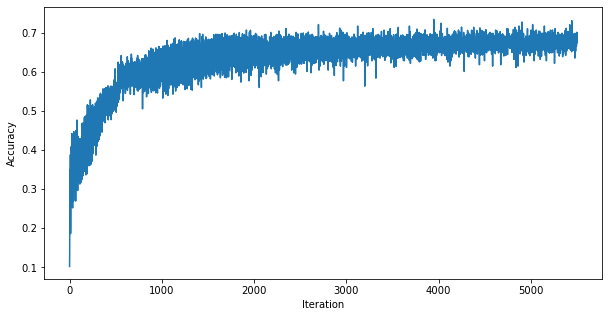

In [16]:
plt.figure(figsize=(10, 5))
plt.ylabel("Accuracy")
plt.xlabel('Iteration')
plt.plot(accs, label='Accuracy vs iteration')
plt.show()

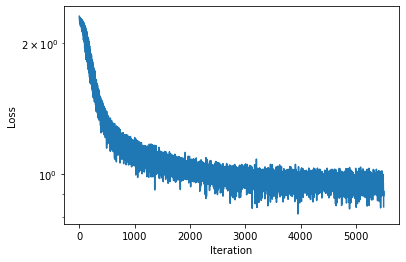

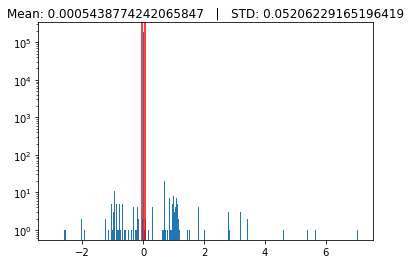

In [17]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.plot(losses, label='Loss vs iteration')
plt.yscale("log")
plt.show()

plt.figure()
weights = tree.inner_nodes.weight.cpu().detach().numpy().flatten()
plt.hist(weights, bins=500)
weights_std = np.std(weights)
weights_mean = np.mean(weights)
plt.axvline(weights_mean + weights_std, color='r')
plt.axvline(weights_mean - weights_std, color='r')
plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
plt.yscale("log")
plt.show()

# Tree Visualization

Average height: 7.579710144927536


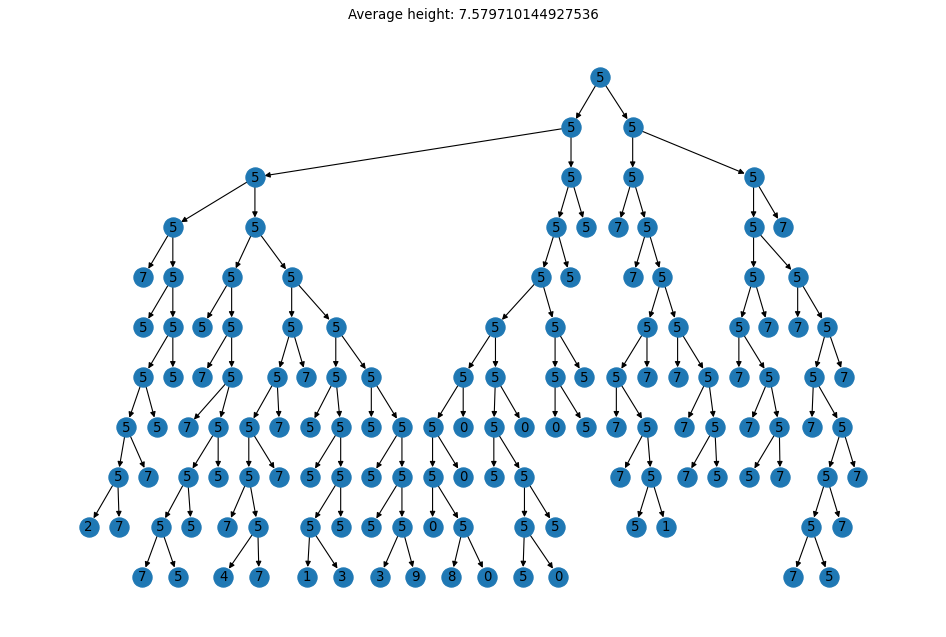

In [18]:
plt.figure(figsize=(15, 10), dpi=80)
avg_height, root = tree.visualize()

# Extract Rules

# Accumulate samples in the leaves

In [19]:
print(f"Number of patterns: {len(root.get_leaves())}")

Number of patterns: 69


In [20]:
method = 'MLE'

In [21]:
root.clear_leaves_samples()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
        root.accumulate_samples(data, method)

/home/eitan.k/miniconda3/envs/rambo/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Tighten boundaries

In [22]:
signal_names = dataset.dataset.all_signals
normalizers = torch.tensor([])
attr_names = []
for signal_name in signal_names:
    attr_names += [f"T{i}.{signal_name}" for i in range(sampled.shape[-1])]
    sensor_norm = torch.tensor([torch.tensor(dataset.dataset.sensor_maxs[signal_name]) for _ in range(sampled.shape[-1])])
    normalizers = torch.cat([normalizers, sensor_norm])
    

# print(attr_names)
leaves = root.get_leaves()
sum_comprehensibility = 0
comprehensibilities = []
for pattern_counter, leaf in enumerate(leaves):
    leaf.reset_path()
    leaf.tighten_with_accumulated_samples()
    conds = leaf.get_path_conditions(attr_names)
    for cond in conds:
        cond.weights = cond.weights / normalizers
    print(f"============== Pattern {pattern_counter + 1} ==============")
    comprehensibilities.append(sum([cond.comprehensibility for cond in conds]))
    
print(f"Average comprehensibility: {np.mean(comprehensibilities)}")
print(f"std comprehensibility: {np.std(comprehensibilities)}")
print(f"var comprehensibility: {np.var(comprehensibilities)}")
print(f"minimum comprehensibility: {np.min(comprehensibilities)}")
print(f"maximum comprehensibility: {np.max(comprehensibilities)}")

/home/eitan.k/EntangledExplainableClustering/soft_decision_tree/sdt_model.py:14: RuntimeWarning: divide by zero encountered in log
  return np.log(1 / (1 - x))


============== Pattern 1 ==============
20293
============== Pattern 2 ==============
============== Pattern 3 ==============
============== Pattern 4 ==============
============== Pattern 5 ==============
============== Pattern 6 ==============
============== Pattern 7 ==============
============== Pattern 8 ==============
============== Pattern 9 ==============
============== Pattern 10 ==============
============== Pattern 11 ==============
============== Pattern 12 ==============
============== Pattern 13 ==============
============== Pattern 14 ==============
============== Pattern 15 ==============
============== Pattern 16 ==============
============== Pattern 17 ==============
============== Pattern 18 ==============
============== Pattern 19 ==============
============== Pattern 20 ==============
============== Pattern 21 ==============
============== Pattern 22 ==============
============== Pattern 23 ==============
============== Pattern 24 ==============
============== Patt